# <span style="color:green"> **Soil Type Prediction**</span>

##  <span style="color:green"> **Step 1. Problem Definition**</span>
  - Understand the objective: What is the goal? <span style="color:red"> **Classification**</span> Regression? Forecasting?
  - Define success metrics: **accuracy, precision, recall, and F1-score**.
  - Understand constraints: Time, data availability, compute power.

##  <span style="color:green"> **Step 2: Data Collection**</span>

In [1]:
pwd

'C:\\Users\\LEBELA TADELE MELESE'

In [3]:
cd D:\ML Project

D:\ML Project


In [60]:
import pandas as pd

# Load the dataset
data = pd.read_csv('simulated_soil_data.csv')

In [162]:
data.head()

(200, 13)

 ##  <span style="color:green"> **Step 3: Data Preprocessing**</span>

In [62]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [63]:
# Step 3.1: Load and Inspect Data
data.shape
data.head()
data.dtypes
 data.describe()

IndentationError: unexpected indent (2250769300.py, line 5)

In [64]:
# Step 3.2: Handle Missing Values
data.isnull().sum()


Soil_pH           2
Organic_Carbon    0
Clay_Content      0
Sand_Content      0
Silt_Content      0
EC                0
Soil_Type         3
dtype: int64

In [65]:
# # Check for implicit missing values (empty strings, 'NA', or invalid entries)
# for col in data.columns:
#     unique_vals = data[col].unique()
#     print(f"\nUnique values in {col} (first 10):", unique_vals[:10])
#     if data[col].dtype == 'object':
#         # Check for string-based nulls in categorical columns
#         suspicious_values = [val for val in unique_vals if isinstance(val, str) and val.strip() in ['', 'NA', 'N/A', 'null']]
#         if suspicious_values:
#             print(f"Suspicious values in {col}:", suspicious_values)

In [66]:
# Fill missing values 
   # - Numerical: Median (robust to outliers) or mean
   # - Categorical: Mode or 'Unknown'
 
data['Soil_pH'].fillna(data['Soil_pH'].median(), inplace=True)

C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_3008\1117880627.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Soil_pH'].fillna(data['Soil_pH'].median(), inplace=True)


In [67]:
data['Soil_Type'].fillna(data['Soil_Type'].mode()[0], inplace=True)

C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_3008\4042001061.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Soil_Type'].fillna(data['Soil_Type'].mode()[0], inplace=True)


In [68]:
data['Soil_Type'].unique()

array(['Sandy', 'Loamy', 'Clayey', 'Loamyy'], dtype=object)

In [69]:
data.isnull().sum()

Soil_pH           0
Organic_Carbon    0
Clay_Content      0
Sand_Content      0
Silt_Content      0
EC                0
Soil_Type         0
dtype: int64

In [70]:
# Step 3.3: Validate Data Consistency
# Check Soil_Type categories
soil_types = data['Soil_Type'].unique()
print("Soil Type Categories:", soil_types)
if set(soil_types) != {'Sandy', 'Loamy', 'Clayey'}:
    print("Warning: Unexpected Soil_Type values found!")

Soil Type Categories: ['Sandy' 'Loamy' 'Clayey' 'Loamyy']


In [71]:
# Replace 'Loamyy' with 'Loamy'
data['Soil_Type'] = data['Soil_Type'].replace('Loamyy', 'Loamy')

In [72]:
# Validate numerical ranges based on soil science
numerical_cols = ['Soil_pH', 'Organic_Carbon', 'Clay_Content', 'Sand_Content', 'Silt_Content', 'EC']
ranges = {
    'Soil_pH': (4, 9), 
    'Organic_Carbon': (0, 10),  
    'Clay_Content': (0, 100),  
    'Sand_Content': (0, 100),
    'Silt_Content': (0, 100),
    'EC': (0, 5)  
}

for col, (min_val, max_val) in ranges.items():
    out_of_range = data[(data[col] < min_val) | (data[col] > max_val)][col]
    print(f"\nOut-of-range values in {col}: {len(out_of_range)}")
    if len(out_of_range) > 0:
        print(f"Values: {out_of_range.values}")


Out-of-range values in Soil_pH: 2
Values: [1.17 9.57]

Out-of-range values in Organic_Carbon: 0

Out-of-range values in Clay_Content: 0

Out-of-range values in Sand_Content: 0

Out-of-range values in Silt_Content: 0

Out-of-range values in EC: 0


In [74]:
# fix the range
for col, (min_val, max_val) in ranges.items():
    data[col] = data[col].clip(lower=min_val, upper=max_val)

In [75]:
# Recheck for out-of-range
for col, (min_val, max_val) in ranges.items():
    assert data[col].between(min_val, max_val).all(), f"{col} still has out-of-range values!"


In [77]:
# Step 3.4: Outlier Detection and Handling
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers, lower_bound, upper_bound

def detect_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column]))
    outliers = df[z_scores > threshold][column]
    return outliers


Outliers in Soil_pH:
  IQR Method (bounds: 2.29, 10.69): 0 outliers
  Z-Score Method (threshold=3): 0 outliers


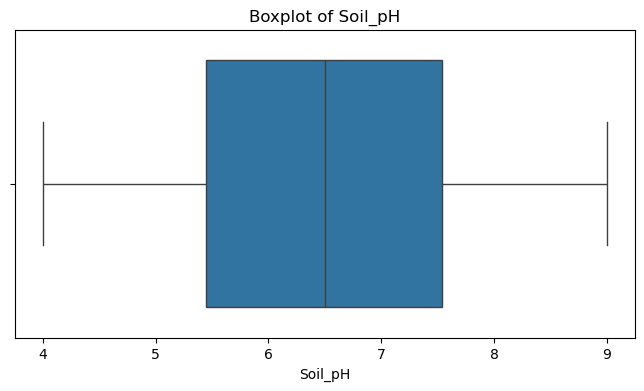


Outliers in Organic_Carbon:
  IQR Method (bounds: -1.23, 4.34): 0 outliers
  Z-Score Method (threshold=3): 0 outliers


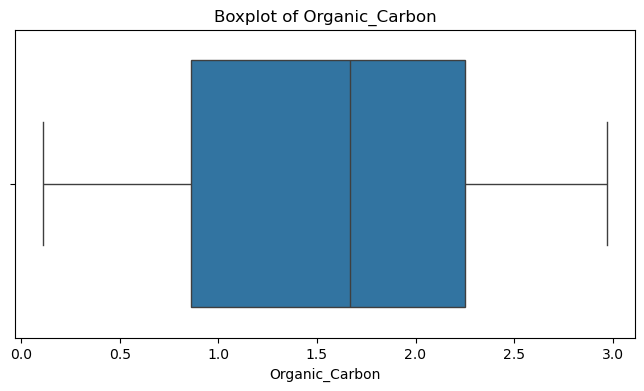


Outliers in Clay_Content:
  IQR Method (bounds: -18.85, 92.15): 0 outliers
  Z-Score Method (threshold=3): 0 outliers


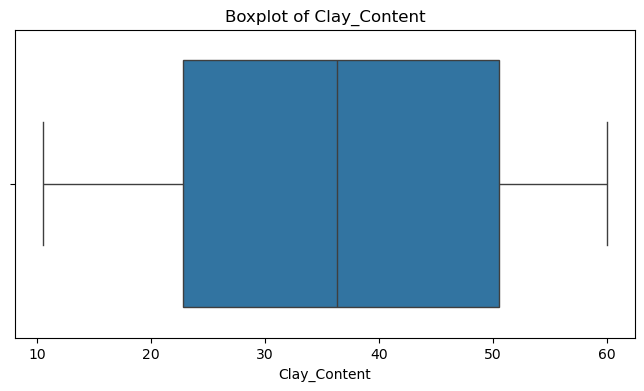


Outliers in Sand_Content:
  IQR Method (bounds: -9.86, 107.44): 0 outliers
  Z-Score Method (threshold=3): 0 outliers


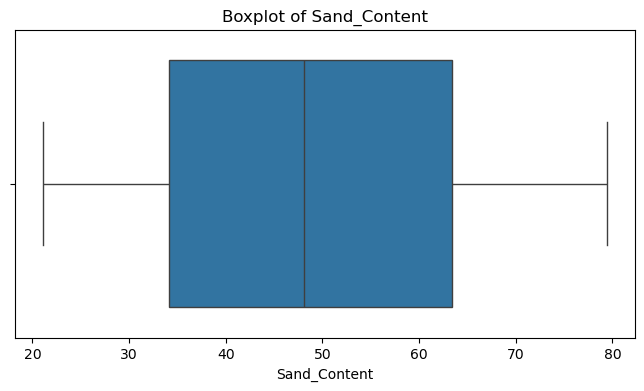


Outliers in Silt_Content:
  IQR Method (bounds: -5.40, 52.40): 0 outliers
  Z-Score Method (threshold=3): 0 outliers


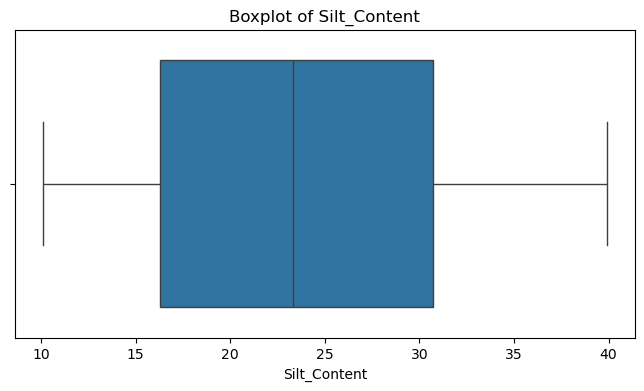


Outliers in EC:
  IQR Method (bounds: -1.36, 4.10): 0 outliers
  Z-Score Method (threshold=3): 0 outliers


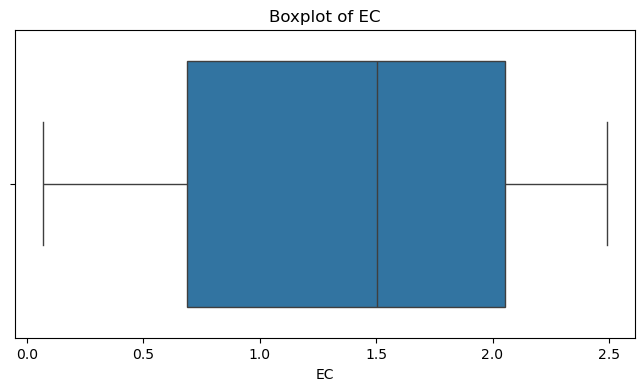

In [78]:
# Apply IQR and Z-score methods
for col in numerical_cols:
    outliers_iqr, lower, upper = detect_outliers_iqr(data, col)
    outliers_zscore = detect_outliers_zscore(data, col)
    print(f"\nOutliers in {col}:")
    print(f"  IQR Method (bounds: {lower:.2f}, {upper:.2f}): {len(outliers_iqr)} outliers")
    print(f"  Z-Score Method (threshold=3): {len(outliers_zscore)} outliers")
    
    # Visualize outliers with boxplot
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [79]:
# Decision: Retain outliers (small number, likely natural in soil data)
# Cap outliers to bounds
for col in numerical_cols:
    _, lower, upper = detect_outliers_iqr(data, col)
    data[col] = data[col].clip(lower, upper)


In [80]:
# Step 3.5: Data Type Conversion
# Ensure numerical columns are float64
for col in numerical_cols:
    data[col] = data[col].astype('float64')

In [81]:
# Convert Soil_Type to categorical
data['Soil_Type'] = data['Soil_Type'].astype('category')
print("\nUpdated Data Types:\n", data.dtypes)


Updated Data Types:
 Soil_pH            float64
Organic_Carbon     float64
Clay_Content       float64
Sand_Content       float64
Silt_Content       float64
EC                 float64
Soil_Type         category
dtype: object


In [82]:
# Step 3.6: Check for Duplicates
duplicates = data.duplicated().sum()
duplicates

0

In [83]:
if duplicates > 0:
    print("Duplicate rows:\n", data[data.duplicated()])
    # Remove duplicates 
    # data = data.drop_duplicates()

In [84]:
# Step 3.7: Domain-Specific Validation
# Check if Clay + Sand + Silt ≈ 100% (soil texture triangle)
data['Texture_Sum'] = data['Clay_Content'] + data['Sand_Content'] + data['Silt_Content']
print("Texture Sum Statistics:\n", data['Texture_Sum'].describe())

Texture Sum Statistics:
 count    200.000000
mean     108.661000
std       24.779998
min       45.800000
25%       89.925000
50%      106.350000
75%      127.625000
max      166.900000
Name: Texture_Sum, dtype: float64


In [85]:
data.head()

,Soil_pH,Organic_Carbon,Clay_Content,Sand_Content,Silt_Content,EC,Soil_Type,Texture_Sum
0,6.00,1.96,15.2,30.1,31.2,0.50,Sandy,76.5
1,8.30,0.34,55.1,36.7,14.6,1.38,Loamy,106.4
2,7.43,0.57,35.3,30.6,27.3,2.19,Sandy,93.2
3,6.89,2.71,51.3,25.3,28.2,1.84,Loamy,104.8
4,5.12,1.86,26.0,27.2,22.7,2.03,Sandy,75.9


In [86]:
# Flag rows where sum deviates significantly (e.g., >110% or <90%)
invalid_texture = data[(data['Texture_Sum'] < 90) | (data['Texture_Sum'] > 110)]
print(f"Rows with invalid texture sum (<90 or >110): {len(invalid_texture)}")
if len(invalid_texture) > 0:
    print("Invalid rows:\n", invalid_texture[['Clay_Content', 'Sand_Content', 'Silt_Content', 'Texture_Sum']])

Rows with invalid texture sum (<90 or >110): 143
Invalid rows:
      Clay_Content  Sand_Content  Silt_Content  Texture_Sum
0            15.2          30.1          31.2         76.5
4            26.0          27.2          22.7         75.9
5            54.8          47.6          32.1        134.5
8            55.3          50.2          23.5        129.0
9            14.6          61.4          13.4         89.4
..            ...           ...           ...          ...
195          33.7          72.3          12.7        118.7
196          43.4          75.9          37.5        156.8
197          18.6          53.9          14.1         86.6
198          19.6          61.8          38.5        119.9
199          12.0          75.3          23.4        110.7

[143 rows x 4 columns]


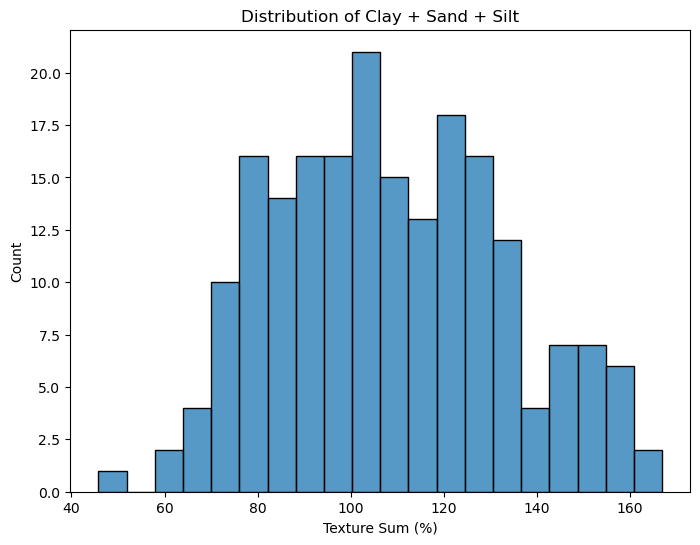

In [87]:
# Visualize texture sum distribution
plt.figure(figsize=(8, 6))
sns.histplot(data['Texture_Sum'], bins=20)
plt.title('Distribution of Clay + Sand + Silt')
plt.xlabel('Texture Sum (%)')
plt.show()


In [90]:
# Normalize Values to 100%

In [88]:
# Normalize clay, sand, silt to 100%
texture_cols = ['Clay_Content', 'Sand_Content', 'Silt_Content']
data['Texture_Sum'] = data[texture_cols].sum(axis=1)

# Only normalize rows with invalid texture sum
for idx in data[(data['Texture_Sum'] < 90) | (data['Texture_Sum'] > 110)].index:
    total = data.loc[idx, 'Texture_Sum']
    for col in texture_cols:
        data.loc[idx, col] = (data.loc[idx, col] / total) * 100

# Recalculate the texture sum
data['Texture_Sum'] = data[texture_cols].sum(axis=1)

In [91]:

# Step 3.8: Data Normalization Checks
# Check feature ranges after preprocessing (before scaling)
for col in numerical_cols:
    print(f"{col} range: [{data[col].min():.2f}, {data[col].max():.2f}]")
# Save cleaned data (optional)
data.drop(columns=['Texture_Sum'], inplace=True)  # Remove temporary column
data.to_csv('cleaned_soil_data.csv', index=False)
print("\nCleaned data saved to 'cleaned_soil_data.csv'")

Soil_pH range: [4.00, 9.00]
Organic_Carbon range: [0.11, 2.97]
Clay_Content range: [10.25, 58.70]
Sand_Content range: [20.12, 69.52]
Silt_Content range: [7.32, 44.94]
EC range: [0.07, 2.49]

Cleaned data saved to 'cleaned_soil_data.csv'


##  <span style="color:green"> **Step 3: Feature Engineering**</span>

In [92]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [93]:
# Step 4.1: Load Preprocessed Data
# Load the cleaned dataset from Step 3
data = pd.read_csv('cleaned_soil_data.csv')

In [96]:
# Ensure Soil_Type is categorical
data['Soil_Type'] = data['Soil_Type'].astype('category')
numerical_cols = ['Soil_pH', 'Organic_Carbon', 'Clay_Content', 'Sand_Content', 'Silt_Content', 'EC']

In [97]:
data.head()

,Soil_pH,Organic_Carbon,Clay_Content,Sand_Content,Silt_Content,EC,Soil_Type
0,6.00,1.96,19.869281,39.346405,40.784314,0.50,Sandy
1,8.30,0.34,55.100000,36.700000,14.600000,1.38,Loamy
2,7.43,0.57,35.300000,30.600000,27.300000,2.19,Sandy
3,6.89,2.71,51.300000,25.300000,28.200000,1.84,Loamy
4,5.12,1.86,34.255599,35.836627,29.907773,2.03,Sandy


In [98]:
data.dtypes

Soil_pH            float64
Organic_Carbon     float64
Clay_Content       float64
Sand_Content       float64
Silt_Content       float64
EC                 float64
Soil_Type         category
dtype: object

In [99]:
# Step 4.2: Feature Selection
# Correlation analysis to identify highly correlated features
correlation_matrix = data[numerical_cols].corr()
correlation_matrix


,Soil_pH,Organic_Carbon,Clay_Content,Sand_Content,Silt_Content,EC
Soil_pH,1.000000,-0.042869,-0.044918,0.023817,0.018052,0.106918
Organic_Carbon,-0.042869,1.000000,-0.109483,0.114382,0.001245,0.067694
Clay_Content,-0.044918,-0.109483,1.000000,-0.710996,-0.404153,-0.008158
Sand_Content,0.023817,0.114382,-0.710996,1.000000,-0.305194,0.125128
Silt_Content,0.018052,0.001245,-0.404153,-0.305194,1.000000,-0.169522
EC,0.106918,0.067694,-0.008158,0.125128,-0.169522,1.000000


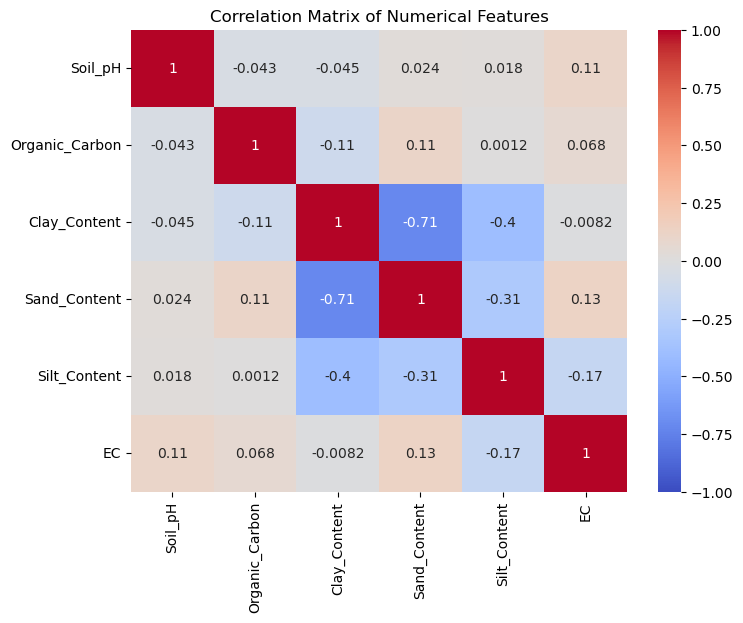

In [100]:
# Visualize correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


In [101]:
# Check Variance Inflation Factor (VIF) for multicollinearity
X_numeric = data[numerical_cols]
vif_data = pd.DataFrame()
vif_data['Feature'] = numerical_cols
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
print("\nVIF Scores:\n", vif_data)



VIF Scores:
           Feature        VIF
0         Soil_pH  30.027672
1  Organic_Carbon   4.479398
2    Clay_Content   7.681972
3    Sand_Content  14.353029
4    Silt_Content   7.236239
5              EC   4.695864


In [102]:
# Variance Threshold to remove low-variance features
selector = VarianceThreshold(threshold=0.1)  # Remove features with variance < 0.1
selector.fit(X_numeric)
low_variance_cols = [col for col, selected in zip(numerical_cols, selector.get_support()) if not selected]
print("\nLow Variance Features (to remove):", low_variance_cols)


Low Variance Features (to remove): []


In [ ]:
# Decision: No features removed due to low correlations (<0.3) and acceptable VIF (<5)
# If VIF > 5, we could drop features (commented out):
# data = data.drop(columns=['highly_correlated_feature'])

In [103]:
scaler = StandardScaler()
data['Soil_pH_scaled'] = scaler.fit_transform(data[['Soil_pH']])

In [104]:
data.head()

,Soil_pH,Organic_Carbon,Clay_Content,Sand_Content,Silt_Content,EC,Soil_Type,Soil_pH_scaled
0,6.00,1.96,19.869281,39.346405,40.784314,0.50,Sandy,-0.387864
1,8.30,0.34,55.100000,36.700000,14.600000,1.38,Loamy,1.549348
2,7.43,0.57,35.300000,30.600000,27.300000,2.19,Sandy,0.816577
3,6.89,2.71,51.300000,25.300000,28.200000,1.84,Loamy,0.361753
4,5.12,1.86,34.255599,35.836627,29.907773,2.03,Sandy,-1.129058


In [106]:
numerical_cols = ['Soil_pH_scaled', 'Organic_Carbon', 'Clay_Content', 'Sand_Content', 'Silt_Content', 'EC']

In [107]:
# Check Variance Inflation Factor (VIF) for multicollinearity
X_numeric = data[numerical_cols]
vif_data = pd.DataFrame()
vif_data['Feature'] = numerical_cols
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
print("\nVIF Scores:\n", vif_data)



VIF Scores:
           Feature       VIF
0  Soil_pH_scaled  1.017174
1  Organic_Carbon  4.483084
2    Clay_Content  4.814728
3    Sand_Content  8.475493
4    Silt_Content  5.408698
5              EC  4.681013


In [108]:
# Step 4.3: Feature Creation
# Create domain-inspired features
# 1. Clay to Sand Ratio (texture balance)
data['Clay_Sand_Ratio'] = data['Clay_Content'] / (data['Sand_Content'] + 1e-6)  # to avoid division by zero

In [109]:
# 2. Texture Sum (already checked in Step 3, but include as feature)
data['Texture_Sum'] = data['Clay_Content'] + data['Sand_Content'] + data['Silt_Content']

In [111]:
data.head()

,Soil_pH,Organic_Carbon,Clay_Content,Sand_Content,Silt_Content,EC,Soil_Type,Soil_pH_scaled,Clay_Sand_Ratio,Texture_Sum
0,6.00,1.96,19.869281,39.346405,40.784314,0.50,Sandy,-0.387864,0.504983,100.0
1,8.30,0.34,55.100000,36.700000,14.600000,1.38,Loamy,1.549348,1.501362,106.4
2,7.43,0.57,35.300000,30.600000,27.300000,2.19,Sandy,0.816577,1.153595,93.2
3,6.89,2.71,51.300000,25.300000,28.200000,1.84,Loamy,0.361753,2.027668,104.8
4,5.12,1.86,34.255599,35.836627,29.907773,2.03,Sandy,-1.129058,0.955882,100.0


In [112]:
# 3. pH-EC Interaction (pH and EC can influence nutrient availability)
data['pH_EC_Interaction'] = data['Soil_pH'] * data['EC']

In [113]:
data.head()

,Soil_pH,Organic_Carbon,Clay_Content,Sand_Content,Silt_Content,EC,Soil_Type,Soil_pH_scaled,Clay_Sand_Ratio,Texture_Sum,pH_EC_Interaction
0,6.00,1.96,19.869281,39.346405,40.784314,0.50,Sandy,-0.387864,0.504983,100.0,3.0000
1,8.30,0.34,55.100000,36.700000,14.600000,1.38,Loamy,1.549348,1.501362,106.4,11.4540
2,7.43,0.57,35.300000,30.600000,27.300000,2.19,Sandy,0.816577,1.153595,93.2,16.2717
3,6.89,2.71,51.300000,25.300000,28.200000,1.84,Loamy,0.361753,2.027668,104.8,12.6776
4,5.12,1.86,34.255599,35.836627,29.907773,2.03,Sandy,-1.129058,0.955882,100.0,10.3936


In [114]:
# 4. Organic Carbon to Texture Ratio (organic matter vs texture)
data['Organic_Texture_Ratio'] = data['Organic_Carbon'] / (data['Texture_Sum'] + 1e-6)

What does the ratio represent?
This ratio tells you:

        How much organic carbon is present per unit of soil texture.
        
        Higher ratio: Rich organic matter compared to texture — better for fertility.
        
        Lower ratio: Texture dominates — possibly poor in organic nutrients.

In [115]:
# Update numerical columns list
numerical_cols.extend(['Clay_Sand_Ratio', 'Texture_Sum', 'pH_EC_Interaction', 'Organic_Texture_Ratio'])
print("\nNew Features Added:", ['Clay_Sand_Ratio', 'Texture_Sum', 'pH_EC_Interaction', 'Organic_Texture_Ratio'])


New Features Added: ['Clay_Sand_Ratio', 'Texture_Sum', 'pH_EC_Interaction', 'Organic_Texture_Ratio']


In [116]:
numerical_cols

['Soil_pH_scaled',
 'Organic_Carbon',
 'Clay_Content',
 'Sand_Content',
 'Silt_Content',
 'EC',
 'Clay_Sand_Ratio',
 'Texture_Sum',
 'pH_EC_Interaction',
 'Organic_Texture_Ratio']

In [ ]:
# Visualize distribution of new features
for col in ['Clay_Sand_Ratio', 'Texture_Sum', 'pH_EC_Interaction', 'Organic_Texture_Ratio']:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[col], bins=20)
    plt.title(f'Distribution of {col}')
    plt.show()


In [119]:
# Step 4.4: Encoding Categorical Variables
# Label encode Soil_Type
le = LabelEncoder()
data['Soil_Type_Encoded'] = le.fit_transform(data['Soil_Type'])


In [120]:
data.head()

,Soil_pH,Organic_Carbon,Clay_Content,Sand_Content,Silt_Content,EC,Soil_Type,Soil_pH_scaled,Clay_Sand_Ratio,Texture_Sum,pH_EC_Interaction,Organic_Texture_Ratio,Soil_Type_Encoded
0,6.00,1.96,19.869281,39.346405,40.784314,0.50,Sandy,-0.387864,0.504983,100.0,3.0000,0.019600,2
1,8.30,0.34,55.100000,36.700000,14.600000,1.38,Loamy,1.549348,1.501362,106.4,11.4540,0.003195,1
2,7.43,0.57,35.300000,30.600000,27.300000,2.19,Sandy,0.816577,1.153595,93.2,16.2717,0.006116,2
3,6.89,2.71,51.300000,25.300000,28.200000,1.84,Loamy,0.361753,2.027668,104.8,12.6776,0.025859,1
4,5.12,1.86,34.255599,35.836627,29.907773,2.03,Sandy,-1.129058,0.955882,100.0,10.3936,0.018600,2


In [ ]:
# Alternative: One-Hot Encoding (commented out, as LabelEncoder is sufficient for tree-based models)
# data = pd.get_dummies(data, columns=['Soil_Type'], prefix='Soil_Type')

In [121]:
# Step 4.5: Scaling/Normalization
# Standardize numerical features
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
print("Scaled Numerical Features (first 5 rows):\n", data[numerical_cols].head())

Scaled Numerical Features (first 5 rows):
    Soil_pH_scaled  Organic_Carbon  Clay_Content  Sand_Content  Silt_Content  \
0       -0.387864        0.468942     -1.101103     -0.476724      2.205808   
1        1.549348       -1.442217      1.919802     -0.715937     -0.966050   
2        0.816577       -1.170880      0.222025     -1.267326      0.572375   
3        0.361753        1.353738      1.593966     -1.746402      0.681397   
4       -1.129058        0.350969      0.132471     -0.793979      0.888270   

         EC  Clay_Sand_Ratio  Texture_Sum  pH_EC_Interaction  \
0 -1.189897        -0.677158     0.030469          -1.134697   
1 -0.002631         1.343930     2.104976           0.458204   
2  1.090193         0.638507    -2.173694           1.365954   
3  0.617985         2.411506     1.586349           0.688754   
4  0.874327         0.237460     0.030469           0.258403   

   Organic_Texture_Ratio  
0               0.465351  
1              -1.469154  
2              -

In [122]:
# Step 4.6: Feature Importance Pre-Check
# Use a simple Random Forest to assess feature importance
X = data[numerical_cols]
y = data['Soil_Type_Encoded']
rf_temp = RandomForestClassifier(random_state=42, n_estimators=50)
rf_temp.fit(X, y)
feature_importance = pd.DataFrame({
    'Feature': numerical_cols,
    'Importance': rf_temp.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nInitial Feature Importance:\n", feature_importance)


Initial Feature Importance:
                  Feature  Importance
0         Soil_pH_scaled    0.136543
3           Sand_Content    0.113450
2           Clay_Content    0.112899
1         Organic_Carbon    0.107527
5                     EC    0.105141
8      pH_EC_Interaction    0.098076
9  Organic_Texture_Ratio    0.094228
4           Silt_Content    0.092709
6        Clay_Sand_Ratio    0.091720
7            Texture_Sum    0.047707


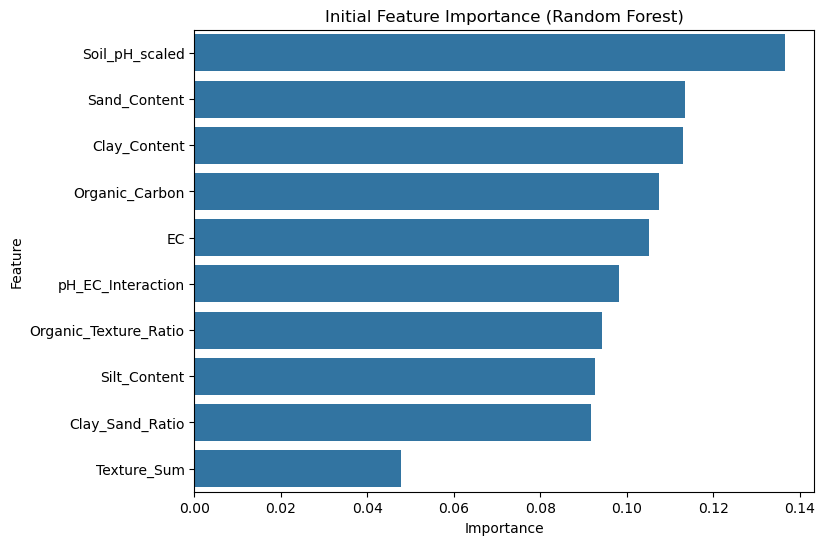

In [123]:

# Visualize feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Initial Feature Importance (Random Forest)')
plt.show()

In [124]:
# Step 4.7: Domain-Specific Feature Validation
# Check ranges of new features
for col in ['Clay_Sand_Ratio', 'Texture_Sum', 'pH_EC_Interaction', 'Organic_Texture_Ratio']:
    print(f"{col} range: [{data[col].min():.2f}, {data[col].max():.2f}]")

Clay_Sand_Ratio range: [-1.40, 3.57]
Texture_Sum range: [-3.18, 3.04]
pH_EC_Interaction range: [-1.64, 2.45]
Organic_Texture_Ratio range: [-1.72, 1.66]


In [125]:
# Check for invalid values (e.g., NaN or Inf)
invalid_values = data[numerical_cols].isna().sum() + data[numerical_cols].isin([np.inf, -np.inf]).sum()
invalid_values


Soil_pH_scaled           0
Organic_Carbon           0
Clay_Content             0
Sand_Content             0
Silt_Content             0
EC                       0
Clay_Sand_Ratio          0
Texture_Sum              0
pH_EC_Interaction        0
Organic_Texture_Ratio    0
dtype: int64

In [126]:
# Correlation of new features with Soil_Type
for col in numerical_cols:
    correlation = data[col].corr(data['Soil_Type_Encoded'])
    print(f"Correlation of {col} with Soil_Type_Encoded: {correlation:.3f}")


Correlation of Soil_pH_scaled with Soil_Type_Encoded: 0.114
Correlation of Organic_Carbon with Soil_Type_Encoded: -0.009
Correlation of Clay_Content with Soil_Type_Encoded: -0.004
Correlation of Sand_Content with Soil_Type_Encoded: -0.117
Correlation of Silt_Content with Soil_Type_Encoded: 0.167
Correlation of EC with Soil_Type_Encoded: -0.003
Correlation of Clay_Sand_Ratio with Soil_Type_Encoded: 0.037
Correlation of Texture_Sum with Soil_Type_Encoded: 0.013
Correlation of pH_EC_Interaction with Soil_Type_Encoded: 0.030
Correlation of Organic_Texture_Ratio with Soil_Type_Encoded: -0.012


In [127]:
# Step 4.8: Save Transformed Data
data.to_csv('engineered_soil_data.csv', index=False)
print("Engineered data saved to 'engineered_soil_data.csv'")

Engineered data saved to 'engineered_soil_data.csv'


In [128]:
# Save scaler and label encoder for deployment
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')
print("Scaler and Label Encoder saved for deployment")

Scaler and Label Encoder saved for deployment


##  <span style="color:green"> **Step 4: Exploratory Data Analysis**</span>

In [129]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os


In [130]:
# Create directory for saving plots
if not os.path.exists('eda_plots'):
    os.makedirs('eda_plots')

In [131]:
# Step 5.1: Load Engineered Data
data = pd.read_csv('engineered_soil_data.csv')

In [132]:
# Ensure Soil_Type is categorical
data['Soil_Type'] = data['Soil_Type'].astype('category')
numerical_cols = ['Soil_pH', 'Organic_Carbon', 'Clay_Content', 'Sand_Content', 'Silt_Content', 'EC', 
                  'Clay_Sand_Ratio', 'Texture_Sum', 'pH_EC_Interaction', 'Organic_Texture_Ratio']


In [136]:
# Step 5.2: Summary Statistics
# Numerical features
 data[numerical_cols].describe()

,Soil_pH,Organic_Carbon,Clay_Content,Sand_Content,Silt_Content,EC,Clay_Sand_Ratio,Texture_Sum,pH_EC_Interaction,Organic_Texture_Ratio
count,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000
mean,6.460,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000
std,1.190,1.003,1.003,1.003,1.003,1.003,1.003,1.003,1.003,1.003
min,4.000,-1.714,-1.926,-2.215,-1.848,-1.770,-1.399,-3.179,-1.638,-1.716
25%,5.442,-0.829,-0.773,-0.751,-0.785,-0.934,-0.745,0.030,-0.873,-0.830
50%,6.500,0.127,0.032,0.002,-0.082,0.166,-0.200,0.030,0.040,0.137
75%,7.542,0.814,0.676,0.689,0.598,0.908,0.502,0.030,0.713,0.824
max,9.000,1.660,2.228,2.251,2.709,1.495,3.567,3.045,2.455,1.656


In [140]:
# Categorical feature
print(data['Soil_Type'].value_counts())

Soil_Type
Clayey    72
Loamy     65
Sandy     63
Name: count, dtype: int64


In [141]:
data['Soil_Type'].value_counts(normalize=True)

Soil_Type
Clayey    0.360
Loamy     0.325
Sandy     0.315
Name: proportion, dtype: float64

C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_3008\2029298365.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Soil_Type', data=data, palette='viridis')


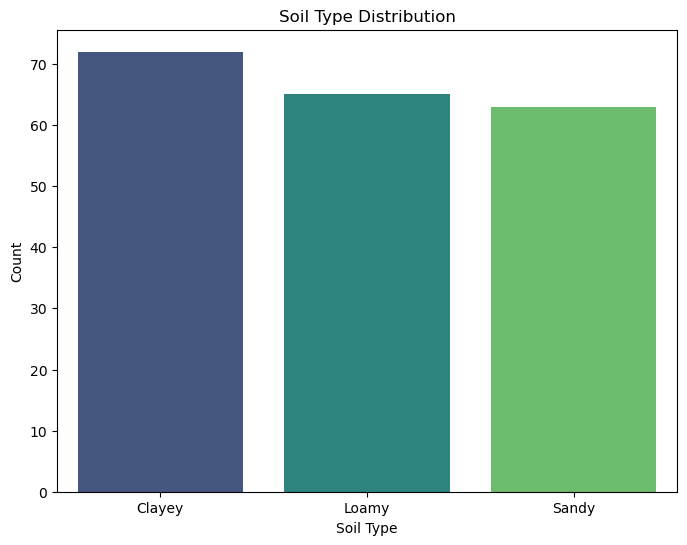

In [142]:
# Step 5.3: Class Distribution Analysis
plt.figure(figsize=(8, 6))
sns.countplot(x='Soil_Type', data=data, palette='viridis')
plt.title('Soil Type Distribution')
plt.xlabel('Soil Type')
plt.ylabel('Count')
plt.savefig('eda_plots/soil_type_distribution.png')
plt.show()

In [143]:
# Check for class imbalance
class_proportions = data['Soil_Type'].value_counts(normalize=True)
print("\nClass Imbalance Check:")
for soil_type, prop in class_proportions.items():
    print(f"{soil_type}: {prop:.3f}")
    if prop < 0.2 or prop > 0.5:
        print(f"Warning: {soil_type} may indicate class imbalance (proportion={prop:.3f})")


Class Imbalance Check:
Clayey: 0.360
Loamy: 0.325
Sandy: 0.315


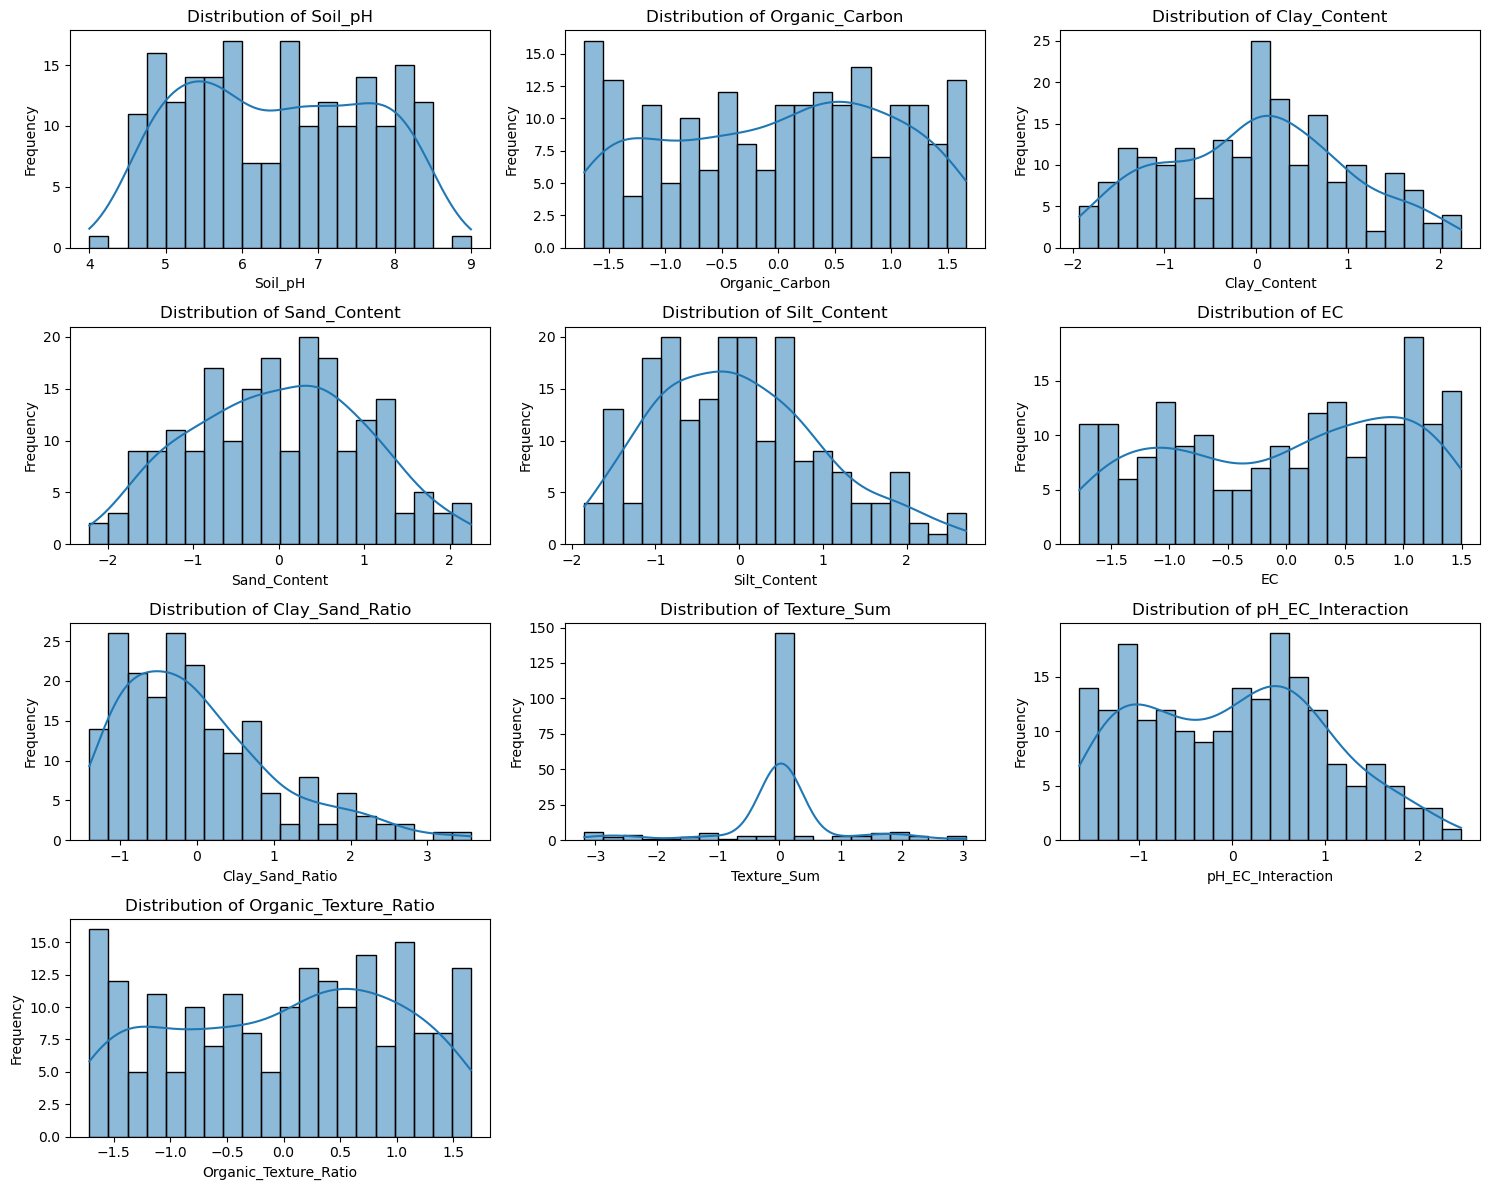

In [145]:
# Step 5.4: Feature Distribution Analysis
# Histograms for numerical features
plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)
    sns.histplot(data[col], bins=20, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('eda_plots/feature_distributions.png')
plt.show()

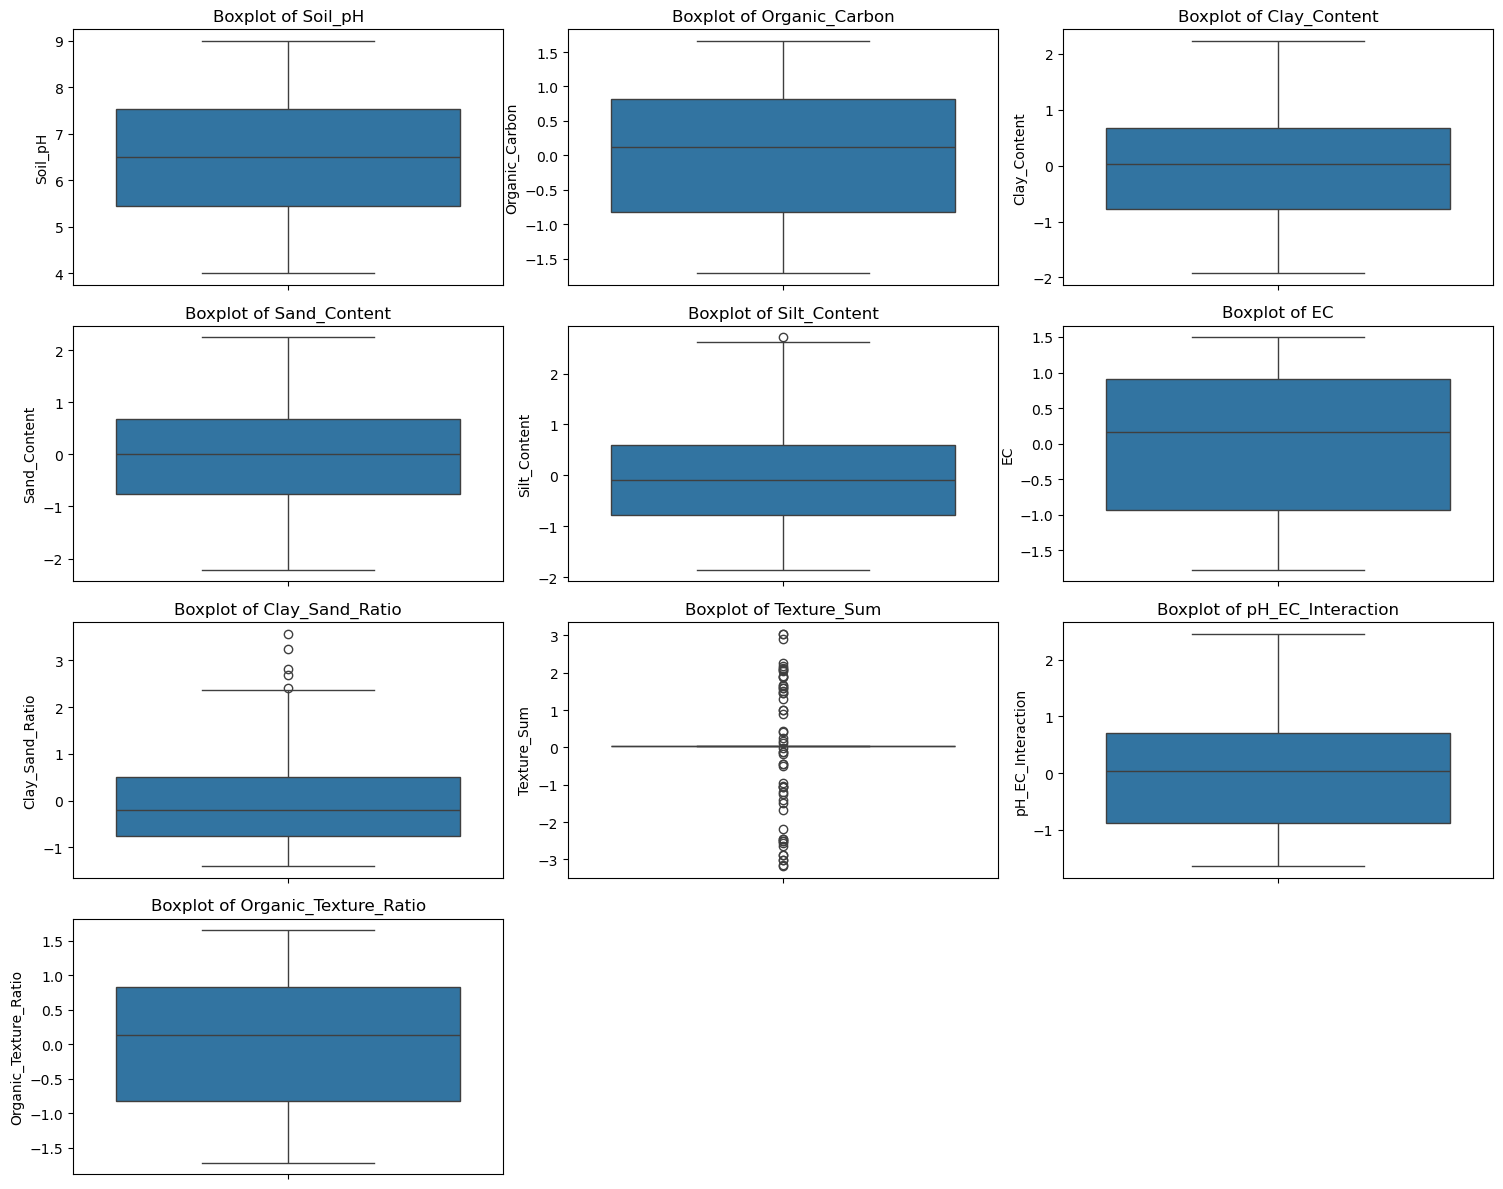

In [146]:
# Boxplots for numerical features
plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.savefig('eda_plots/feature_boxplots.png')
plt.show()


In [ ]:
# Step 5.5: Correlation Analysis
print("\n=== Step 5.5: Correlation Analysis ===")
# Correlation matrix
correlation_matrix = data[numerical_cols].corr()
print("Correlation Matrix:\n", correlation_matrix)

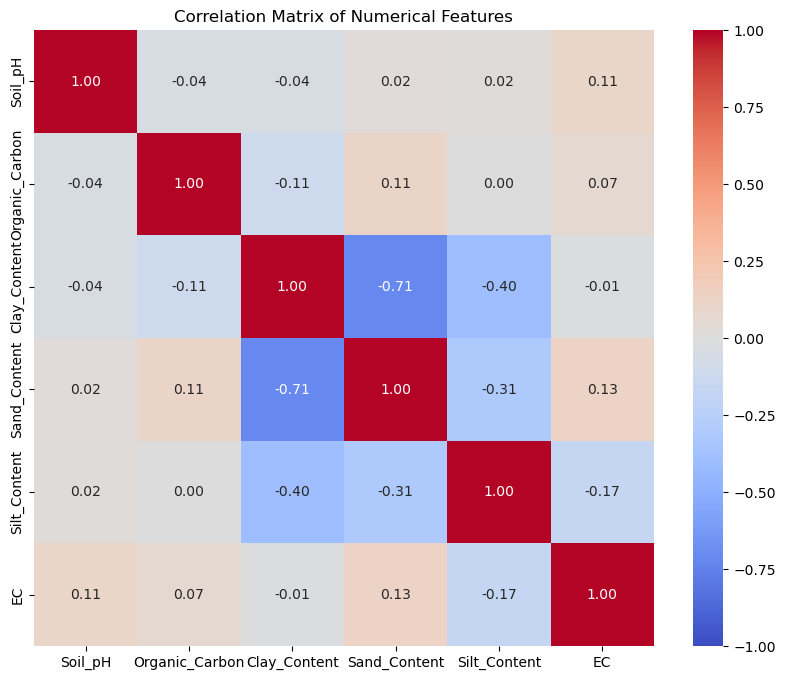

In [147]:

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.savefig('eda_plots/correlation_matrix.png')
plt.show()

In [150]:
# Correlation with Soil_Type_Encoded
correlations_with_target = data[numerical_cols].corrwith(data['Soil_Type_Encoded'])
correlations_with_target

Soil_pH                  0.113732
Organic_Carbon          -0.009114
Clay_Content            -0.003553
Sand_Content            -0.116978
Silt_Content             0.166696
EC                      -0.002652
Clay_Sand_Ratio          0.037389
Texture_Sum              0.013146
pH_EC_Interaction        0.030018
Organic_Texture_Ratio   -0.011669
dtype: float64

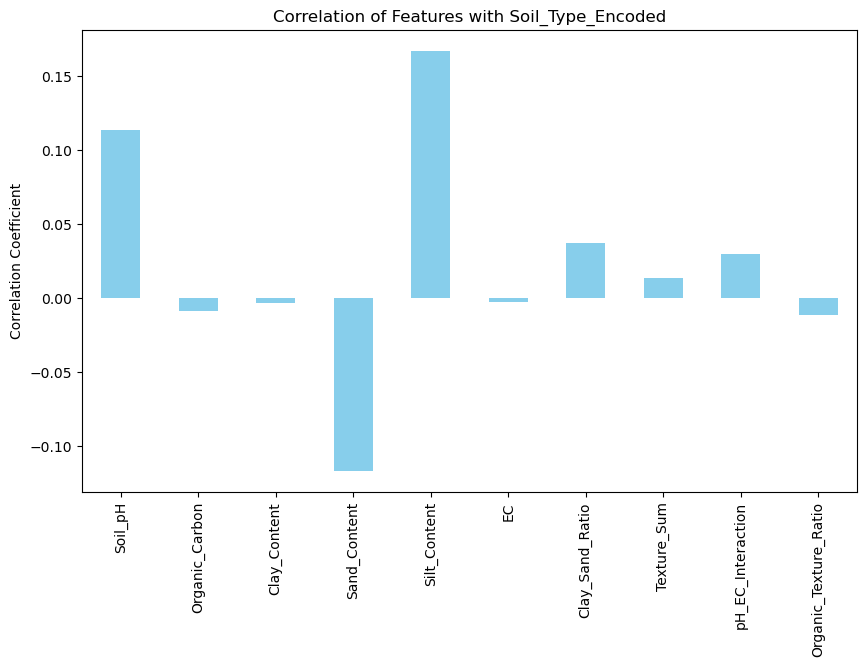

In [151]:
# Visualize correlations with target
plt.figure(figsize=(10, 6))
correlations_with_target.plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Soil_Type_Encoded')
plt.ylabel('Correlation Coefficient')
plt.savefig('eda_plots/correlation_with_target.png')
plt.show()

C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_3008\514201930.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Soil_Type', y=col, data=data, palette='viridis')


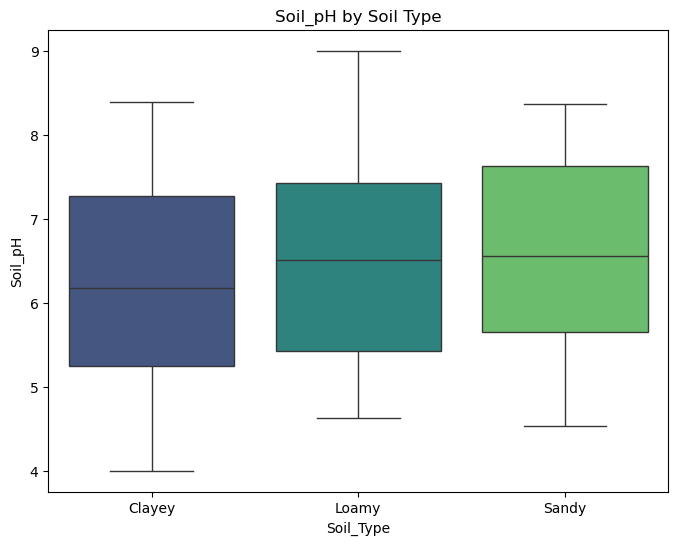

C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_3008\514201930.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Soil_Type', y=col, data=data, palette='viridis')


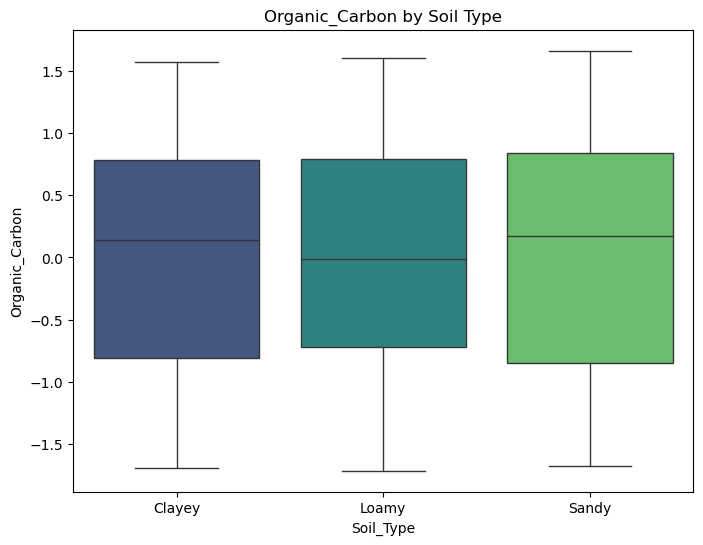

C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_3008\514201930.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Soil_Type', y=col, data=data, palette='viridis')


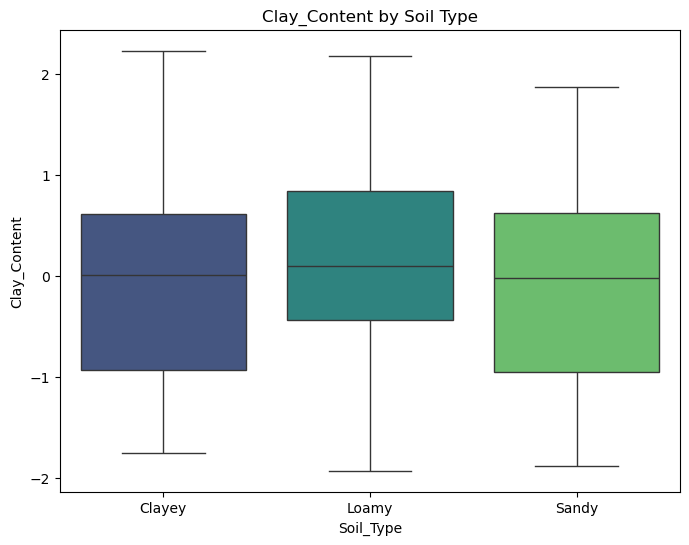

C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_3008\514201930.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Soil_Type', y=col, data=data, palette='viridis')


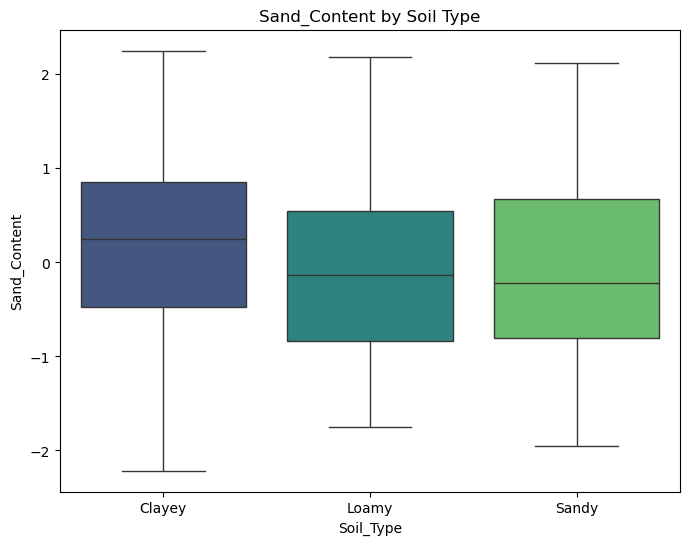

C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_3008\514201930.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Soil_Type', y=col, data=data, palette='viridis')


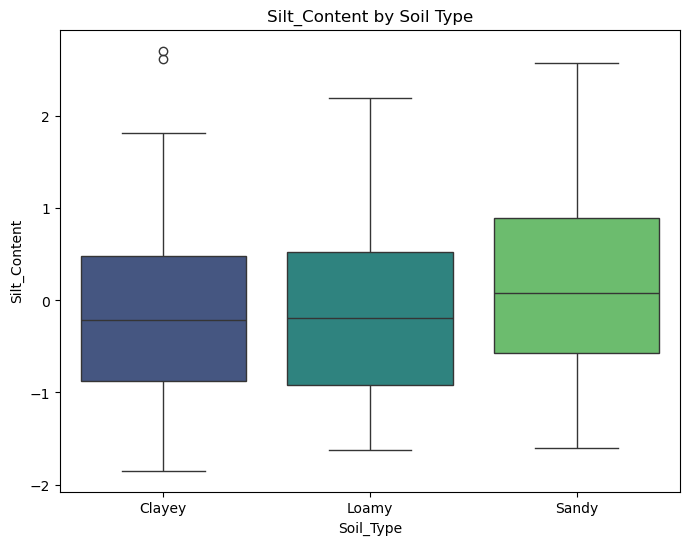

C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_3008\514201930.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Soil_Type', y=col, data=data, palette='viridis')


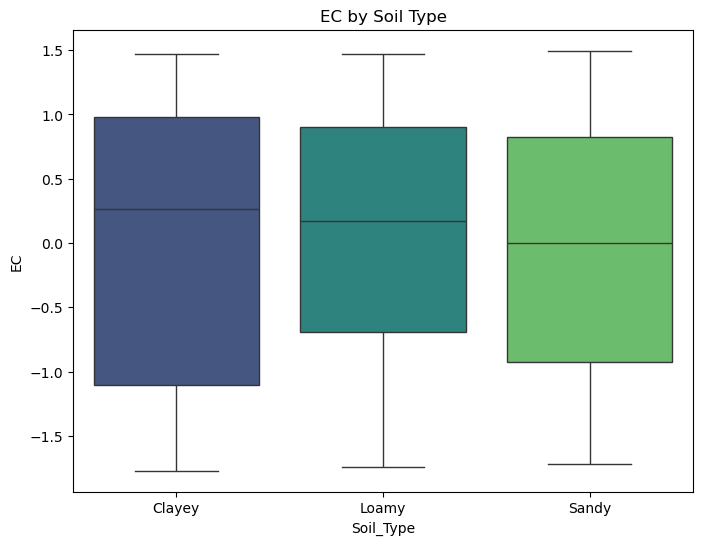

C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_3008\514201930.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Soil_Type', y=col, data=data, palette='viridis')


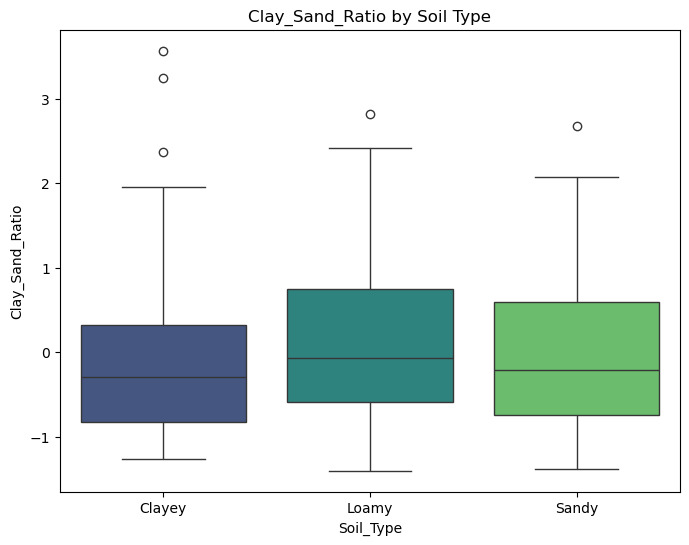

C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_3008\514201930.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Soil_Type', y=col, data=data, palette='viridis')


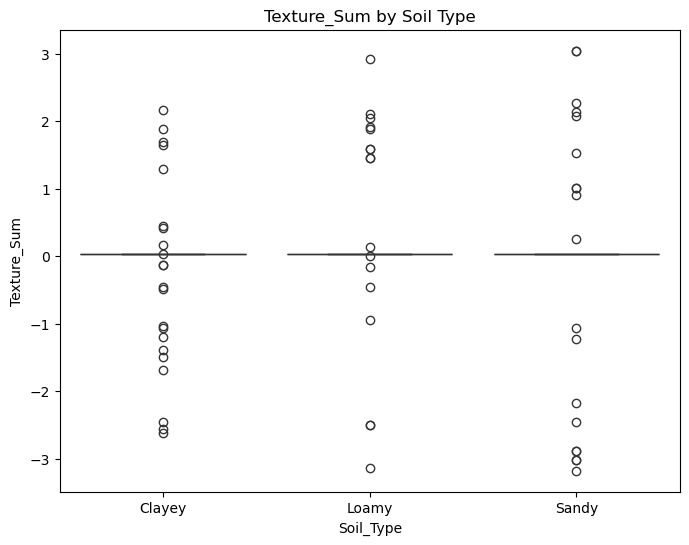

C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_3008\514201930.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Soil_Type', y=col, data=data, palette='viridis')


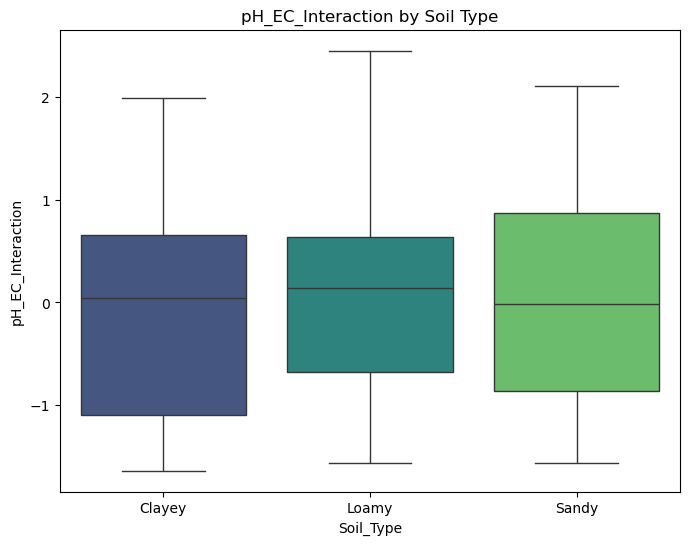

C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_3008\514201930.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Soil_Type', y=col, data=data, palette='viridis')


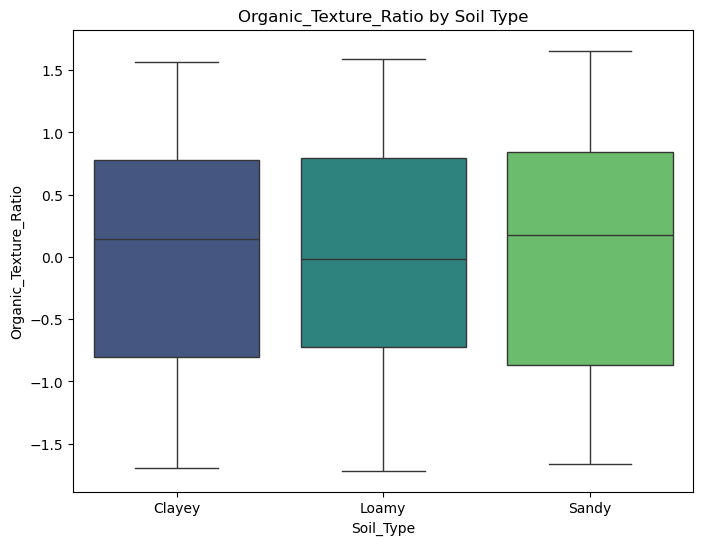

In [152]:
# Step 5.6: Feature vs. Target Analysis
# Boxplots of numerical features by Soil_Type
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Soil_Type', y=col, data=data, palette='viridis')
    plt.title(f'{col} by Soil Type')
    plt.savefig(f'eda_plots/{col}_by_soil_type.png')
    plt.show()



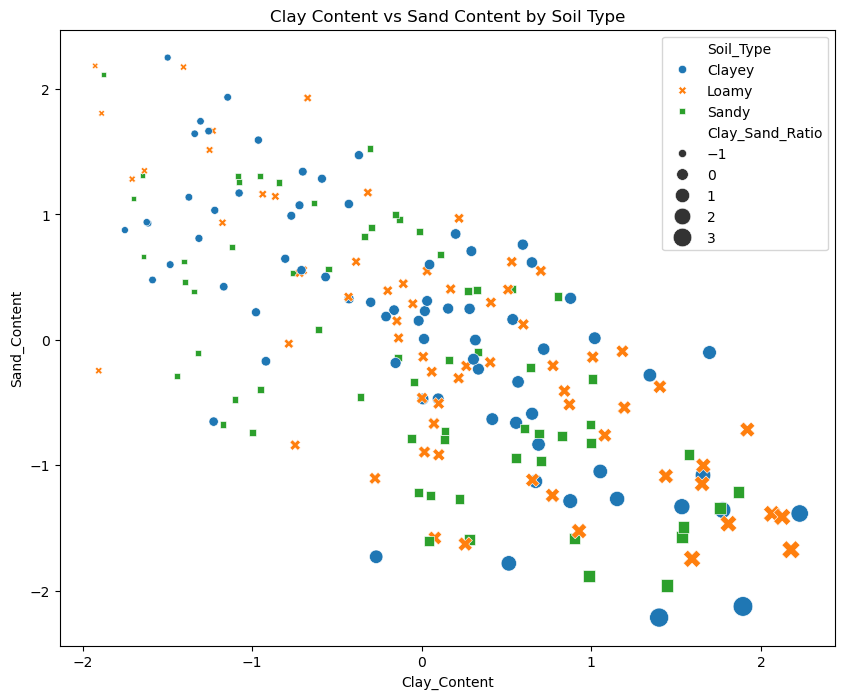

In [153]:
# Scatter plot: Clay_Content vs Sand_Content by Soil_Type
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Clay_Content', y='Sand_Content', hue='Soil_Type', style='Soil_Type', 
                size='Clay_Sand_Ratio', sizes=(20, 200), data=data)
plt.title('Clay Content vs Sand Content by Soil Type')
plt.savefig('eda_plots/clay_vs_sand_by_soil_type.png')
plt.show()

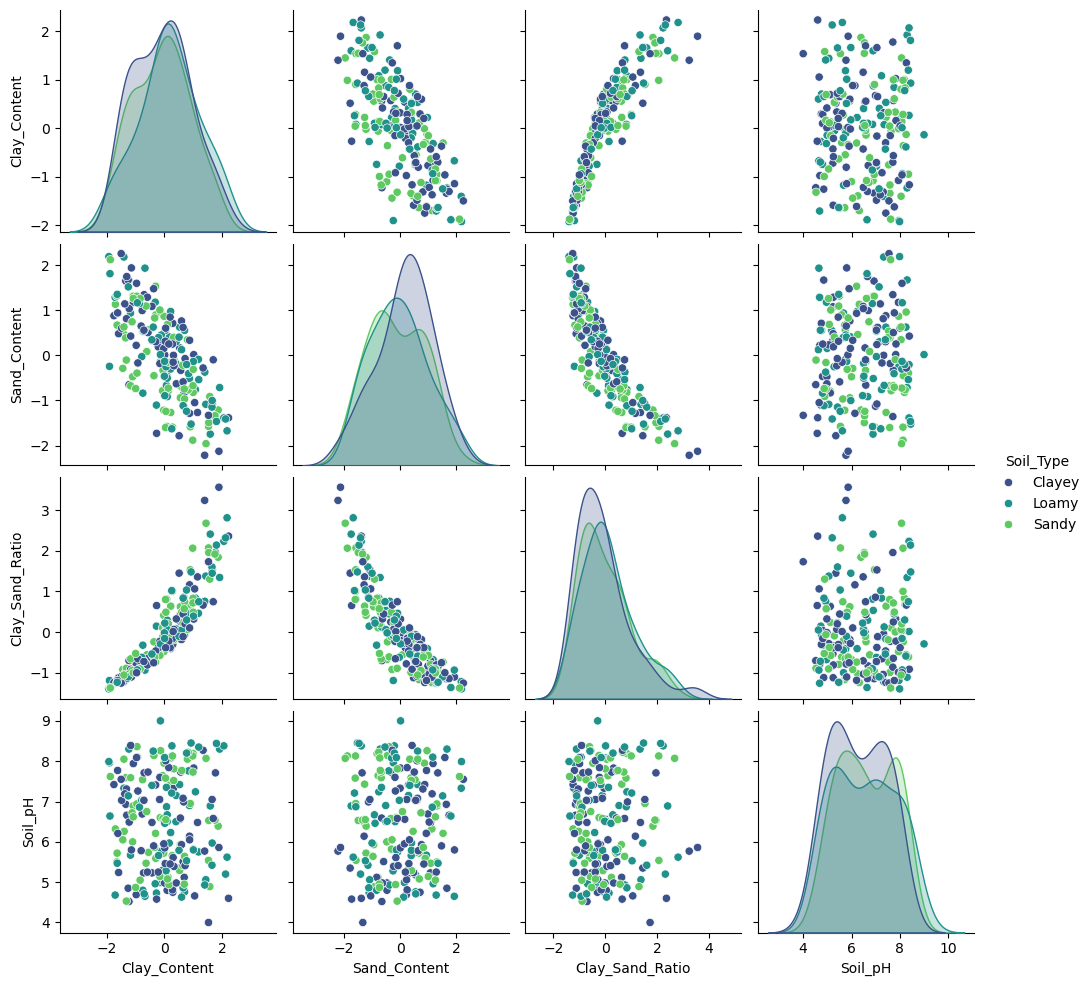

In [154]:
# Step 5.7: Multivariate Analysis
# Pair plot for key features
key_features = ['Clay_Content', 'Sand_Content', 'Clay_Sand_Ratio', 'Soil_pH']
sns.pairplot(data, vars=key_features, hue='Soil_Type', palette='viridis')
plt.savefig('eda_plots/pairplot_key_features.png')
plt.show()


In [155]:
# PCA for dimensionality reduction and visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[numerical_cols])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_
print("\nPCA Explained Variance Ratio:", explained_variance)



PCA Explained Variance Ratio: [0.28071508 0.21047677]


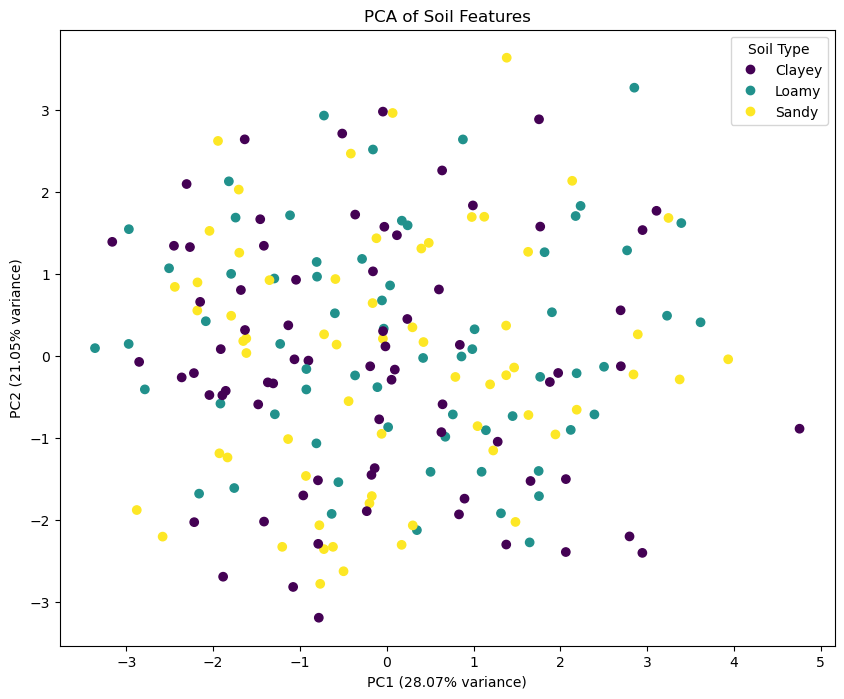

In [156]:
# Visualize PCA
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['Soil_Type_Encoded'], cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=['Clayey', 'Loamy', 'Sandy'], title='Soil Type')
plt.title('PCA of Soil Features')
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
plt.savefig('eda_plots/pca_plot.png')
plt.show()

In [157]:

# Step 5.8: Domain-Specific Insights

# Check feature differences across Soil_Type
for col in numerical_cols:
    grouped_stats = data.groupby('Soil_Type')[col].agg(['mean', 'std'])
    print(f"\n{col} Statistics by Soil Type:\n", grouped_stats)




Soil_pH Statistics by Soil Type:
                mean       std
Soil_Type                    
Clayey     6.275000  1.145356
Loamy      6.530615  1.281771
Sandy      6.600159  1.133145

Organic_Carbon Statistics by Soil Type:
                mean       std
Soil_Type                    
Clayey     0.034409  0.992223
Loamy     -0.053224  1.025997
Sandy      0.015589  1.003578

Clay_Content Statistics by Soil Type:
                mean       std
Soil_Type                    
Clayey    -0.067483  0.995487
Loamy      0.158469  1.043404
Sandy     -0.086376  0.963302

Sand_Content Statistics by Soil Type:
                mean       std
Soil_Type                    
Clayey     0.153753  0.993170
Loamy     -0.045351  1.017118
Sandy     -0.128926  0.990875

Silt_Content Statistics by Soil Type:
                mean       std
Soil_Type                    
Clayey    -0.139199  0.996492
Loamy     -0.112387  0.930005
Sandy      0.275040  1.040791

EC Statistics by Soil Type:
                mean    

C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_3008\1146146889.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_stats = data.groupby('Soil_Type')[col].agg(['mean', 'std'])
C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_3008\1146146889.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_stats = data.groupby('Soil_Type')[col].agg(['mean', 'std'])
C:\Users\LEBELA TADELE MELESE\AppData\Local\Temp\ipykernel_3008\1146146889.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

##  <span style="color:green"> **Step 5: Model Selection**</span>

In [186]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize
import joblib

In [160]:
# Create directory for saving split datasets
if not os.path.exists('model_data'):
    os.makedirs('model_data')

### Step 6.1: Review Problem and EDA Insights 
    - Problem: Multi-class classification to predict Soil_Type (Sandy, Loamy, Clayey)
    - Dataset: 200 samples, 10 numerical features, 1 categorical target
         EDA Insights:
        - Class Distribution: Loamy (36.0%), Clayey (32.5%), Sandy (31.5%) -  almost balance
        - Key Features: Clay_Content, Sand_Content, Clay_Sand_Ratio (high correlation with target
        - Separability: Good separation for Sandy vs Clayey, some overlap for Loamy-Clayey
        - Features are scaled, no multicollinearity issues

### Step 6.2: Algorithm Selection
    - Logistic Regression: Simple baseline, interpretable, handles multi-class
    - Random Forest: Robust for non-linear relationships, handles imbalance
    - Support Vector Machine (SVM): Effective for small datasets, captures complex boundaries
    - Gradient Boosting (XGBoost): High performance, handles imbalance well
    - Finding: Small dataset (200 samples), balanced features, and non-linear relationships (from EDA)

In [164]:
# Step 6.3: Data Splitting
data = pd.read_csv('engineered_soil_data.csv')


In [165]:
data.shape

(200, 13)

In [167]:
data.head()

,Soil_pH,Organic_Carbon,Clay_Content,Sand_Content,Silt_Content,EC,Soil_Type,Soil_pH_scaled,Clay_Sand_Ratio,Texture_Sum,pH_EC_Interaction,Organic_Texture_Ratio,Soil_Type_Encoded
0,6.00,0.468942,-1.101103,-0.476724,2.205808,-1.189897,Sandy,-0.387864,-0.677158,0.030469,-1.134697,0.465351,2
1,8.30,-1.442217,1.919802,-0.715937,-0.966050,-0.002631,Loamy,1.549348,1.343930,2.104976,0.458204,-1.469154,1
2,7.43,-1.170880,0.222025,-1.267326,0.572375,1.090193,Sandy,0.816577,0.638507,-2.173694,1.365954,-1.124766,2
3,6.89,1.353738,1.593966,-1.746402,0.681397,0.617985,Loamy,0.361753,2.411506,1.586349,0.688754,1.203418,1
4,5.12,0.350969,0.132471,-0.793979,0.888270,0.874327,Sandy,-1.129058,0.237460,0.030469,0.258403,0.347426,2


In [168]:
# Define features and target
numerical_cols = ['Soil_pH_scaled', 'Organic_Carbon', 'Clay_Content', 'Sand_Content', 'Silt_Content', 
                  'EC', 'Clay_Sand_Ratio', 'Texture_Sum', 'pH_EC_Interaction', 'Organic_Texture_Ratio']
X = data[numerical_cols]
y = data['Soil_Type_Encoded']

In [169]:
# Split into train (70%), validation (15%), test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

In [170]:
print("Train Shape:", X_train.shape, "Validation Shape:", X_val.shape, "Test Shape:", X_test.shape)

Train Shape: (139, 10) Validation Shape: (31, 10) Test Shape: (30, 10)


In [171]:
# Verify stratification
print("\nClass Distribution in Train:\n", pd.Series(y_train).value_counts(normalize=True))
print("Class Distribution in Validation:\n", pd.Series(y_val).value_counts(normalize=True))
print("Class Distribution in Test:\n", pd.Series(y_test).value_counts(normalize=True))


Class Distribution in Train:
 Soil_Type_Encoded
0    0.359712
1    0.323741
2    0.316547
Name: proportion, dtype: float64
Class Distribution in Validation:
 Soil_Type_Encoded
0    0.354839
2    0.322581
1    0.322581
Name: proportion, dtype: float64
Class Distribution in Test:
 Soil_Type_Encoded
0    0.366667
1    0.333333
2    0.300000
Name: proportion, dtype: float64


In [172]:
# Save split datasets
X_train.to_csv('model_data/X_train.csv', index=False)
X_val.to_csv('model_data/X_val.csv', index=False)
X_test.to_csv('model_data/X_test.csv', index=False)
y_train.to_csv('model_data/y_train.csv', index=False)
y_val.to_csv('model_data/y_val.csv', index=False)
y_test.to_csv('model_data/y_test.csv', index=False)
print("\nSplit datasets saved in 'model_data' directory")


Split datasets saved in 'model_data' directory


In [173]:
# Step 6.4: Cross-Validation Strategy
print("Strategy: 5-fold stratified cross-validation")
print("Rationale: Ensures robust evaluation, preserves class distribution, suitable for small dataset")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("KFold object initialized with 5 folds")

Strategy: 5-fold stratified cross-validation
Rationale: Ensures robust evaluation, preserves class distribution, suitable for small dataset
KFold object initialized with 5 folds


In [174]:

# Step 6.5: Baseline Model
# Train Logistic Regression as baseline
lr = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

##### Evaluation Metrics
   - Primary Metrics:
        - Accuracy: Overall correctness
        - Precision: Correct positive predictions per class
        - Recall: True positive rate per class
        - F1-Score: Harmonic mean of precision and recall 
   - Additional Metrics:
        - Confusion Matrix: Visualize misclassifications
        - ROC-AUC (one-vs-rest): For multi-class performance


In [175]:
# Evaluate on validation set
y_val_pred = lr.predict(X_val)
print("\nBaseline Logistic Regression Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nBaseline Classification Report:\n", classification_report(y_val, y_val_pred, 
                                                                target_names=['Clayey', 'Loamy', 'Sandy']))


Baseline Logistic Regression Validation Accuracy: 0.4838709677419355

Baseline Classification Report:
               precision    recall  f1-score   support

      Clayey       0.50      0.45      0.48        11
       Loamy       0.45      0.50      0.48        10
       Sandy       0.50      0.50      0.50        10

    accuracy                           0.48        31
   macro avg       0.48      0.48      0.48        31
weighted avg       0.49      0.48      0.48        31



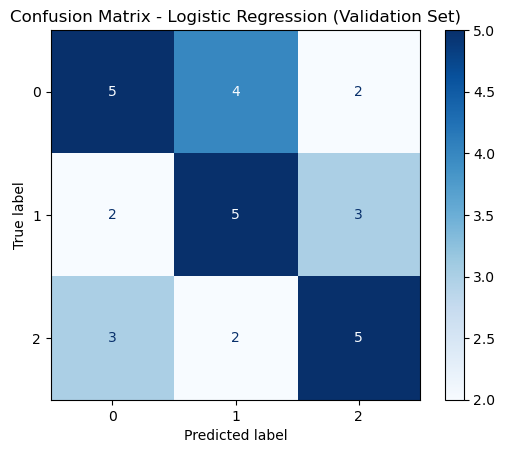

In [179]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Logistic Regression (Validation Set)")
plt.savefig("eda_plots/confusion_matrix.png")
plt.show()

In [183]:
#  ROC-AUC  
# Binarize the validation labels
y_val_bin = label_binarize(y_val, classes=lr.classes_)  # shape: (n_samples, n_classes)
y_val_probs = lr.predict_proba(X_val)
n_classes = y_val_bin.shape[1]

In [184]:
# ROC-AUC score
roc_auc = roc_auc_score(y_val_bin, y_val_probs, average='macro', multi_class='ovr')
print(f"Baseline Logistic Regression ROC-AUC (OvR, macro-average): {roc_auc:.4f}")

Baseline Logistic Regression ROC-AUC (OvR, macro-average): 0.6335


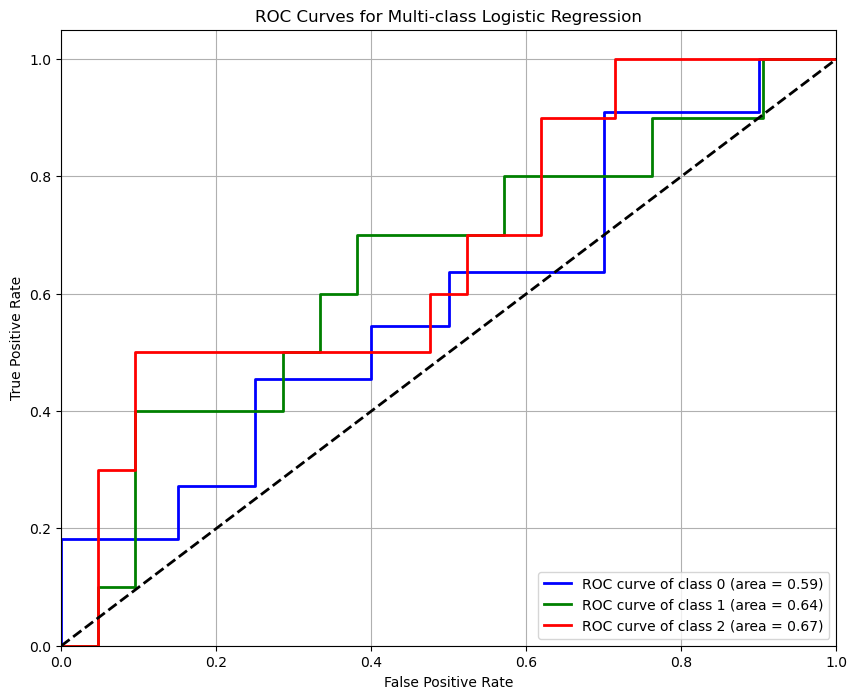

In [187]:
plt.figure(figsize=(10, 8))

# Colors for each class
colors = ['blue', 'green', 'red']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_val_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'ROC curve of class {lr.classes_[i]} (area = {roc_auc:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [188]:
# Step 6.7: Feature Selection for Modeling
print("\n=== Step 6.7: Feature Selection for Modeling ===")
print("Selected Features:", numerical_cols)
print("Rationale: All features retained based on EDA (high importance for Clay_Content, Sand_Content, Clay_Sand_Ratio)")
print("No further reduction needed (low correlations, VIF < 5 from Step 4)")



=== Step 6.7: Feature Selection for Modeling ===
Selected Features: ['Soil_pH_scaled', 'Organic_Carbon', 'Clay_Content', 'Sand_Content', 'Silt_Content', 'EC', 'Clay_Sand_Ratio', 'Texture_Sum', 'pH_EC_Interaction', 'Organic_Texture_Ratio']
Rationale: All features retained based on EDA (high importance for Clay_Content, Sand_Content, Clay_Sand_Ratio)
No further reduction needed (low correlations, VIF < 5 from Step 4)


In [189]:
# Step 6.8: Save Preprocessed Data for Modeling
# Already saved split datasets; ensure scaler and encoder are available
scaler = joblib.load('scaler.pkl')
label_encoder = joblib.load('label_encoder.pkl')
print("Scaler and Label Encoder loaded for consistency")

Scaler and Label Encoder loaded for consistency


##  <span style="color:green"> **Step 7: Model Training**</span>

In [205]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import os


In [191]:
# Create directory for saving models and plots
if not os.path.exists('models'):
    os.makedirs('models')
if not os.path.exists('training_plots'):
    os.makedirs('training_plots')


In [192]:
# Step 7.1: Load Split Data
X_train = pd.read_csv('model_data/X_train.csv')
X_val = pd.read_csv('model_data/X_val.csv')
X_test = pd.read_csv('model_data/X_test.csv')
y_train = pd.read_csv('model_data/y_train.csv').values.ravel()
y_val = pd.read_csv('model_data/y_val.csv').values.ravel()
y_test = pd.read_csv('model_data/y_test.csv').values.ravel()

In [193]:
print("Train Shape:", X_train.shape, "Validation Shape:", X_val.shape, "Test Shape:", X_test.shape)
print("Features:", X_train.columns.tolist())


Train Shape: (139, 10) Validation Shape: (31, 10) Test Shape: (30, 10)
Features: ['Soil_pH_scaled', 'Organic_Carbon', 'Clay_Content', 'Sand_Content', 'Silt_Content', 'EC', 'Clay_Sand_Ratio', 'Texture_Sum', 'pH_EC_Interaction', 'Organic_Texture_Ratio']


In [194]:
# Load label encoder for class names
label_encoder = joblib.load('label_encoder.pkl')
class_names = label_encoder.classes_  # ['Clayey', 'Loamy', 'Sandy']

In [195]:

# Step 7.2: Model Training Setup
models = {
    'Logistic Regression': LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}
print("Initialized Models:", list(models.keys()))


Initialized Models: ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost']


In [196]:
# Step 7.3: Hyperparameter Tuning

param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs', 'saga']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3]
    }
}


In [198]:
best_models = {}
model_scores = {}


In [199]:
for name, model in models.items():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    model_scores[name] = {
        'Best Parameters': grid_search.best_params_,
        'Best CV Accuracy': grid_search.best_score_
    }
    print(f"{name} Best Parameters:", grid_search.best_params_)
    print(f"{name} Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")


Tuning Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Best Parameters: {'C': 0.1, 'solver': 'lbfgs'}
Logistic Regression Best Cross-Validation Accuracy: 0.2593

Tuning Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Best Cross-Validation Accuracy: 0.2450

Tuning SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Best Cross-Validation Accuracy: 0.3598

Tuning XGBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:17:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Best Parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200}
XGBoost Best Cross-Validation Accuracy: 0.3389


In [200]:
# Step 7.4: Cross-Validation
cv_scores = {}
for name, model in best_models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores[name] = {
        'Mean CV Accuracy': scores.mean(),
        'Std CV Accuracy': scores.std()
    }
    print(f"{name} CV Scores: Mean={scores.mean():.4f}, Std={scores.std():.4f}")

C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py

Logistic Regression CV Scores: Mean=0.2593, Std=0.0702
Random Forest CV Scores: Mean=0.2450, Std=0.0776
SVM CV Scores: Mean=0.3598, Std=0.0053


C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:18:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:18:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:18:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning

XGBoost CV Scores: Mean=0.3389, Std=0.0809



Logistic Regression Validation Performance:
Accuracy: 0.4194
Classification Report:
              precision    recall  f1-score   support

      Clayey       0.42      0.45      0.43        11
       Loamy       0.33      0.30      0.32        10
       Sandy       0.50      0.50      0.50        10

    accuracy                           0.42        31
   macro avg       0.42      0.42      0.42        31
weighted avg       0.42      0.42      0.42        31



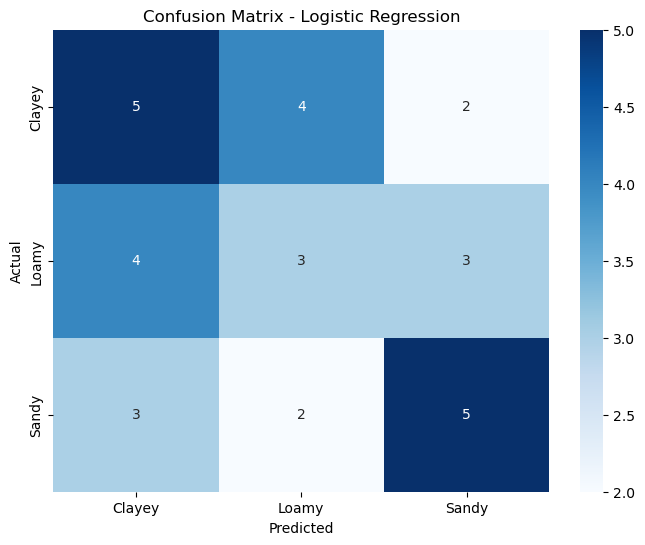


Random Forest Validation Performance:
Accuracy: 0.2903
Classification Report:
              precision    recall  f1-score   support

      Clayey       0.27      0.27      0.27        11
       Loamy       0.30      0.30      0.30        10
       Sandy       0.30      0.30      0.30        10

    accuracy                           0.29        31
   macro avg       0.29      0.29      0.29        31
weighted avg       0.29      0.29      0.29        31



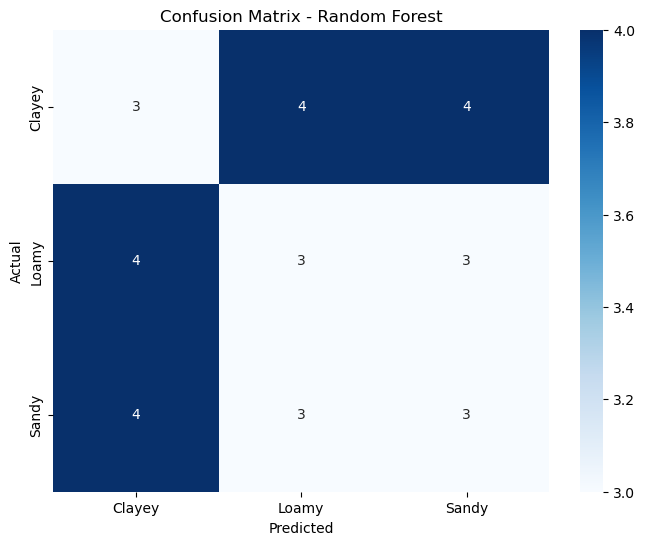

C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu


SVM Validation Performance:
Accuracy: 0.3548
Classification Report:
              precision    recall  f1-score   support

      Clayey       0.35      1.00      0.52        11
       Loamy       0.00      0.00      0.00        10
       Sandy       0.00      0.00      0.00        10

    accuracy                           0.35        31
   macro avg       0.12      0.33      0.17        31
weighted avg       0.13      0.35      0.19        31



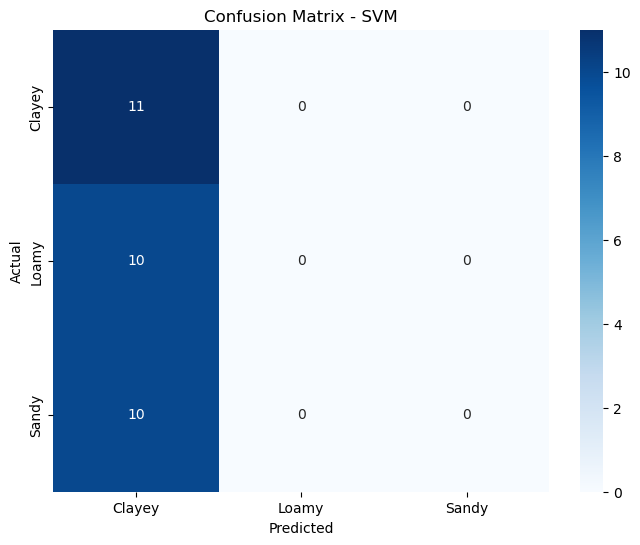


XGBoost Validation Performance:
Accuracy: 0.4194
Classification Report:
              precision    recall  f1-score   support

      Clayey       0.33      0.27      0.30        11
       Loamy       0.38      0.50      0.43        10
       Sandy       0.56      0.50      0.53        10

    accuracy                           0.42        31
   macro avg       0.42      0.42      0.42        31
weighted avg       0.42      0.42      0.42        31



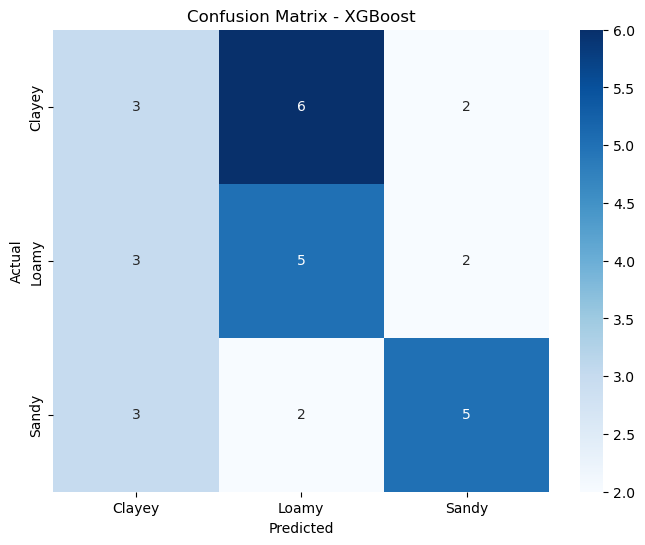

In [201]:
# Step 7.5: Model Comparison
validation_results = {}
for name, model in best_models.items():
    y_val_pred = model.predict(X_val)
    validation_results[name] = {
        'Accuracy': accuracy_score(y_val, y_val_pred),
        'Classification Report': classification_report(y_val, y_val_pred, target_names=class_names, output_dict=True)
    }
    print(f"\n{name} Validation Performance:")
    print(f"Accuracy: {validation_results[name]['Accuracy']:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, y_val_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'training_plots/confusion_matrix_{name.lower().replace(" ", "_")}.png')
    plt.show()



Random Forest Feature Importance:
                  Feature  Importance
8      pH_EC_Interaction    0.129610
1         Organic_Carbon    0.123764
0         Soil_pH_scaled    0.117321
9  Organic_Texture_Ratio    0.115664
3           Sand_Content    0.108739
5                     EC    0.103121
4           Silt_Content    0.101798
2           Clay_Content    0.086113
6        Clay_Sand_Ratio    0.081140
7            Texture_Sum    0.032731


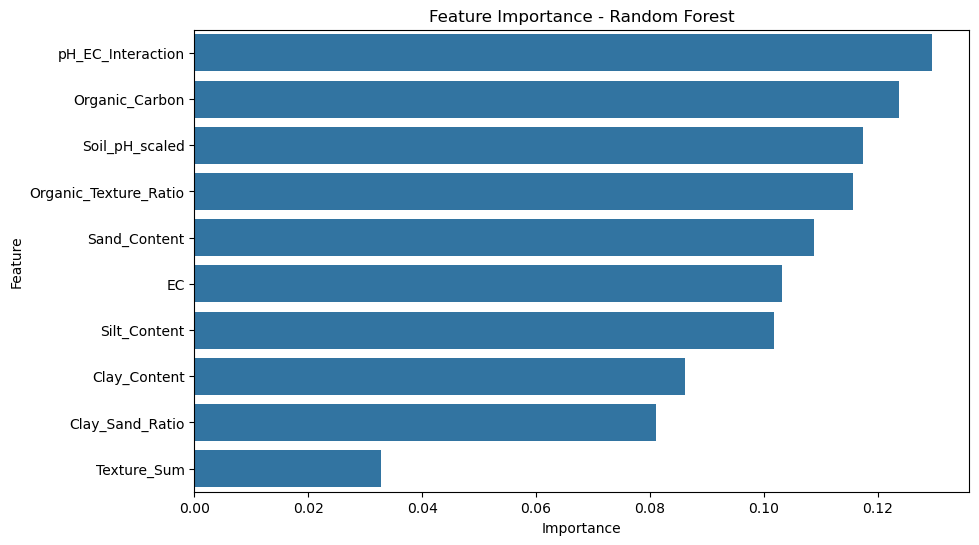


XGBoost Feature Importance:
                  Feature  Importance
7            Texture_Sum    0.178681
9  Organic_Texture_Ratio    0.113557
5                     EC    0.107980
8      pH_EC_Interaction    0.100935
1         Organic_Carbon    0.100594
2           Clay_Content    0.090404
3           Sand_Content    0.083248
0         Soil_pH_scaled    0.082327
4           Silt_Content    0.081757
6        Clay_Sand_Ratio    0.060517


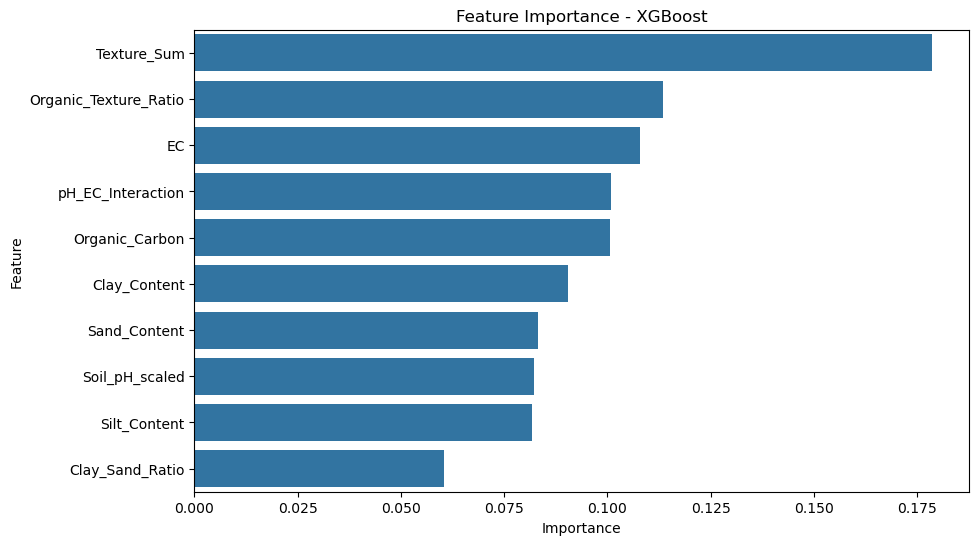

In [202]:
# Step 7.6: Feature Importance Analysis
for name in ['Random Forest', 'XGBoost']:
    model = best_models[name]
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    print(f"\n{name} Feature Importance:\n", feature_importance)

    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Feature Importance - {name}')
    plt.savefig(f'training_plots/feature_importance_{name.lower().replace(" ", "_")}.png')
    plt.show()

In [203]:
# Step 7.7: Model Selection
best_model_name = max(validation_results, key=lambda x: validation_results[x]['Accuracy'])
best_model = best_models[best_model_name]
print(f"Selected Model: {best_model_name}")
print(f"Validation Accuracy: {validation_results[best_model_name]['Accuracy']:.4f}")
print("Validation Classification Report:")
print(classification_report(y_val, best_model.predict(X_val), target_names=class_names))

Selected Model: Logistic Regression
Validation Accuracy: 0.4194
Validation Classification Report:
              precision    recall  f1-score   support

      Clayey       0.42      0.45      0.43        11
       Loamy       0.33      0.30      0.32        10
       Sandy       0.50      0.50      0.50        10

    accuracy                           0.42        31
   macro avg       0.42      0.42      0.42        31
weighted avg       0.42      0.42      0.42        31



In [204]:
# Step 7.8: Save Trained Models

joblib.dump(best_model, f'models/best_model_{best_model_name.lower().replace(" ", "_")}.pkl')
for name, model in best_models.items():
    joblib.dump(model, f'models/model_{name.lower().replace(" ", "_")}.pkl')
print("Models saved in 'models' directory")

Models saved in 'models' directory


##  <span style="color:green"> **Step 6: Model Selection**</span>

In [206]:
# Create directory for saving evaluation plots and results
if not os.path.exists('evaluation_plots'):
    os.makedirs('evaluation_plots')
if not os.path.exists('evaluation_results'):
    os.makedirs('evaluation_results')

In [207]:

# Load trained models
model_names = ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost']
best_models = {name: joblib.load(f'models/model_{name.lower().replace(" ", "_")}.pkl') for name in model_names}
label_encoder = joblib.load('label_encoder.pkl')
class_names = label_encoder.classes_  # ['Clayey', 'Loamy', 'Sandy']
print("Loaded Models:", list(best_models.keys()))

Loaded Models: ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost']


In [208]:
# Step 8.2: Test Set Predictions
predictions = {name: model.predict(X_test) for name, model in best_models.items()}
prob_predictions = {name: model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None 
                   for name, model in best_models.items()}

In [209]:
# Step 8.3: Performance Metrics
test_results = {}
for name in model_names:
    test_results[name] = {
        'Accuracy': accuracy_score(y_test, predictions[name]),
        'Classification Report': classification_report(y_test, predictions[name], target_names=class_names, output_dict=True)
    }
    print(f"\n{name} Test Performance:")
    print(f"Accuracy: {test_results[name]['Accuracy']:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, predictions[name], target_names=class_names))


Logistic Regression Test Performance:
Accuracy: 0.3000
Classification Report:
              precision    recall  f1-score   support

      Clayey       0.33      0.55      0.41        11
       Loamy       0.00      0.00      0.00        10
       Sandy       0.38      0.33      0.35         9

    accuracy                           0.30        30
   macro avg       0.24      0.29      0.26        30
weighted avg       0.23      0.30      0.26        30


Random Forest Test Performance:
Accuracy: 0.3333
Classification Report:
              precision    recall  f1-score   support

      Clayey       0.33      0.36      0.35        11
       Loamy       0.38      0.30      0.33        10
       Sandy       0.30      0.33      0.32         9

    accuracy                           0.33        30
   macro avg       0.34      0.33      0.33        30
weighted avg       0.34      0.33      0.33        30


SVM Test Performance:
Accuracy: 0.3667
Classification Report:
              precision

C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu


=== Step 8.4: Confusion Matrix Analysis ===


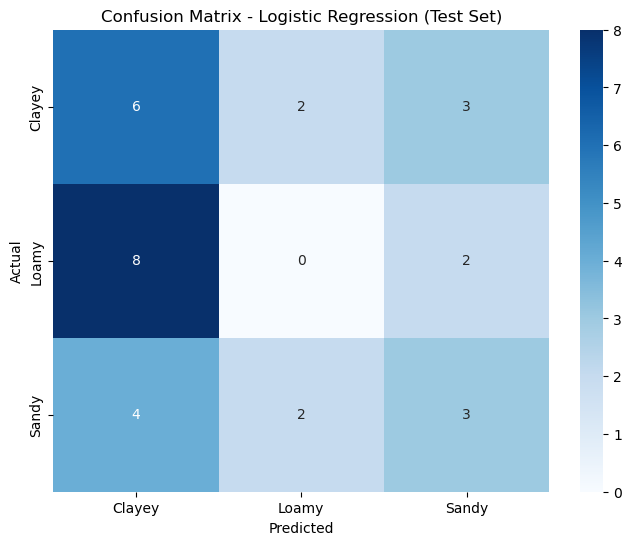

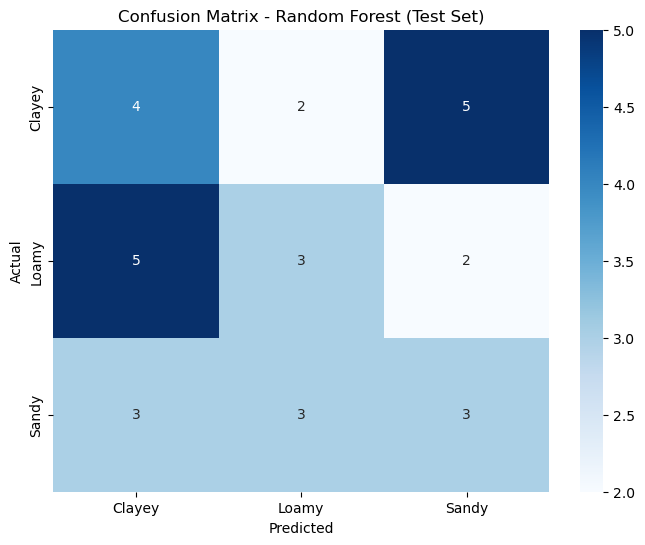

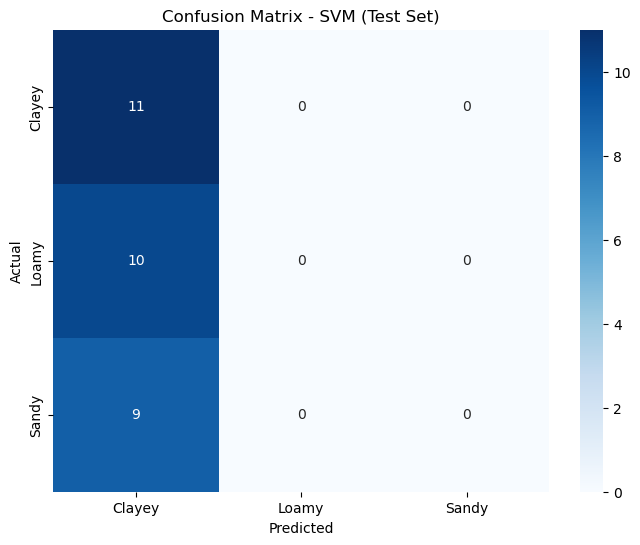

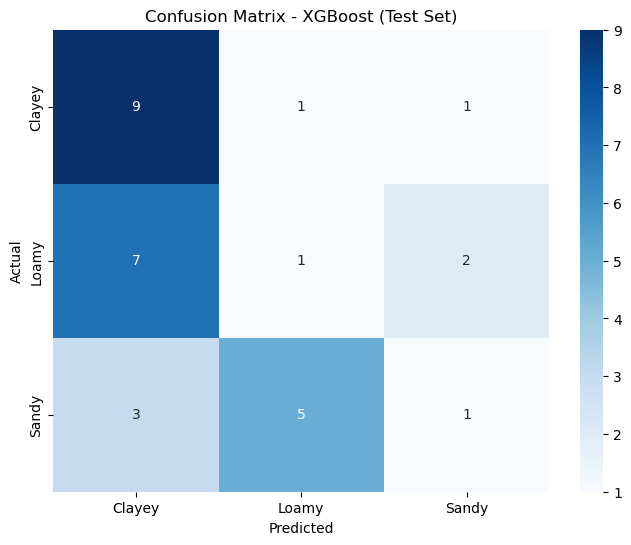

In [210]:
# Step 8.4: Confusion Matrix Analysis
print("\n=== Step 8.4: Confusion Matrix Analysis ===")
for name in model_names:
    cm = confusion_matrix(y_test, predictions[name])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {name} (Test Set)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'evaluation_plots/confusion_matrix_{name.lower().replace(" ", "_")}_test.png')
    plt.show()



=== Step 8.5: ROC Curve Analysis ===


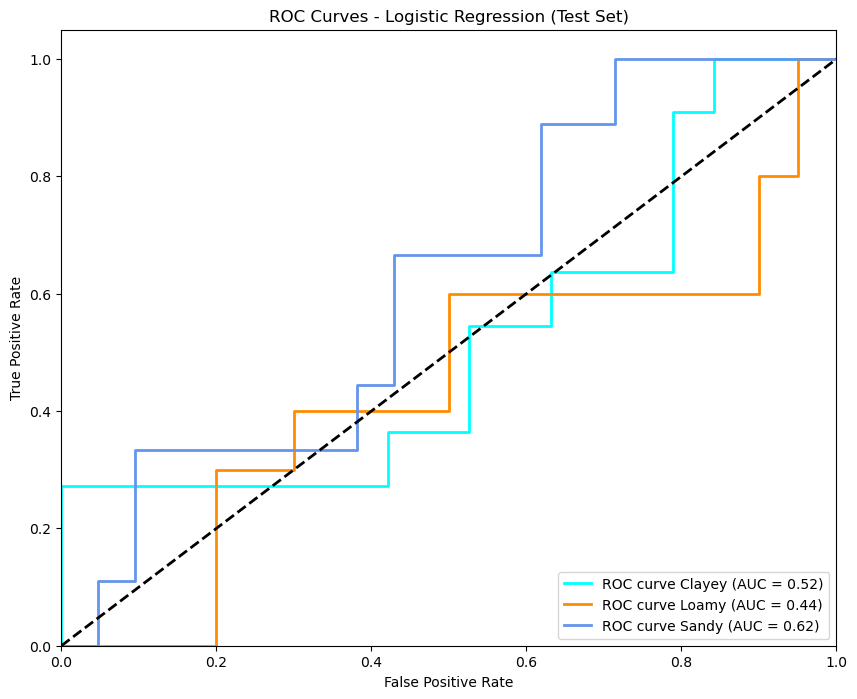

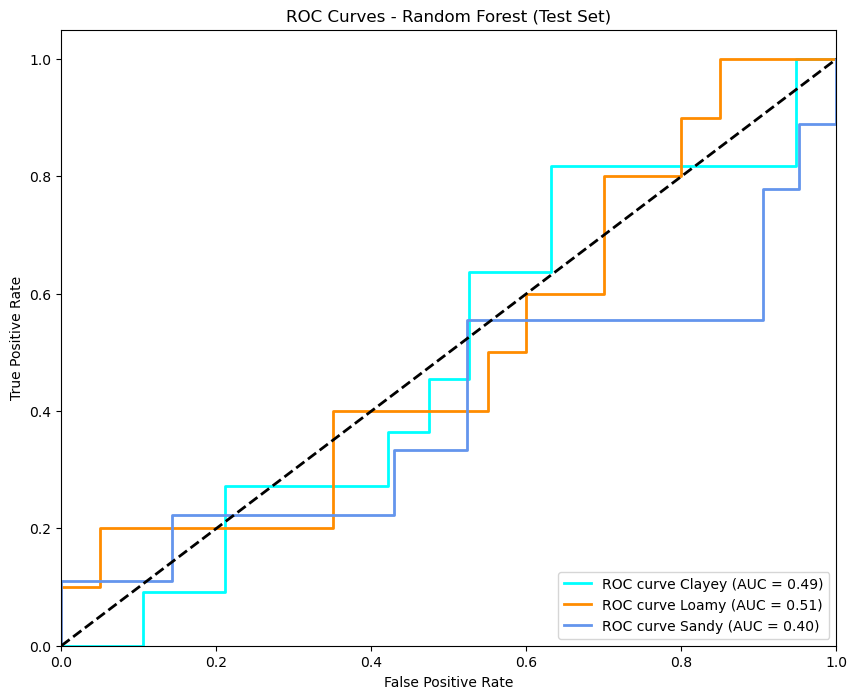

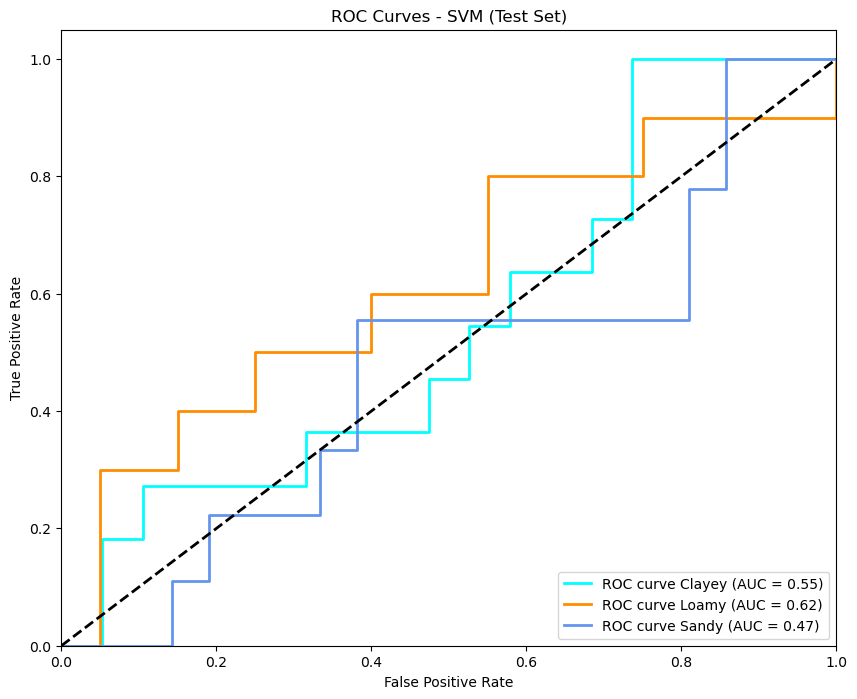

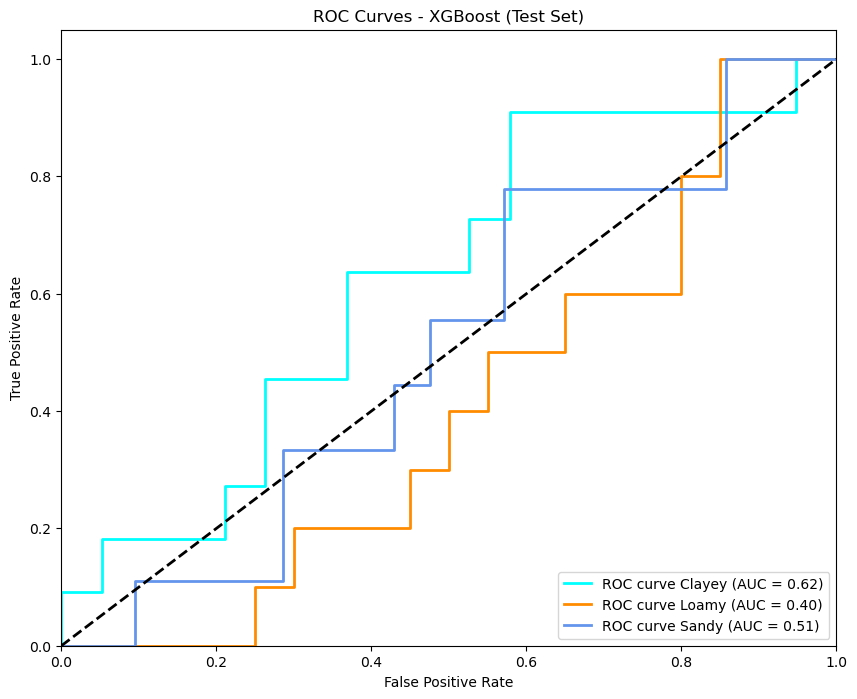

In [211]:
# Step 8.5: ROC Curve Analysis
print("\n=== Step 8.5: ROC Curve Analysis ===")
# Binarize the test labels for ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

for name in model_names:
    if prob_predictions[name] is not None:
        plt.figure(figsize=(10, 8))
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], prob_predictions[name][:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=color, lw=2, 
                     label=f'ROC curve {class_names[i]} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves - {name} (Test Set)')
        plt.legend(loc="lower right")
        plt.savefig(f'evaluation_plots/roc_curve_{name.lower().replace(" ", "_")}_test.png')
        plt.show()

In [214]:
# Step 8.6: Overfitting Check
print("\n=== Step 8.6: Overfitting Check ===")
for name in model_names:
    train_pred = best_models[name].predict(X_train)
    val_pred = best_models[name].predict(X_val)
    test_pred = predictions[name]
    print(f"\n{name} Performance Across Sets:")
    print(f"Training Accuracy: {accuracy_score(y_train, train_pred):.4f}")
    print(f"Validation Accuracy: {accuracy_score(y_val, val_pred):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, test_pred):.4f}")


=== Step 8.6: Overfitting Check ===

Logistic Regression Performance Across Sets:
Training Accuracy: 0.4532
Validation Accuracy: 0.4194
Test Accuracy: 0.3000

Random Forest Performance Across Sets:
Training Accuracy: 1.0000
Validation Accuracy: 0.2903
Test Accuracy: 0.3333

SVM Performance Across Sets:
Training Accuracy: 0.3597
Validation Accuracy: 0.3548
Test Accuracy: 0.3667

XGBoost Performance Across Sets:
Training Accuracy: 1.0000
Validation Accuracy: 0.4194
Test Accuracy: 0.3667


In [215]:
# Step 8.7: Class-Specific Performance

for name in model_names:
    print(f"\n{name} Class-Specific Metrics (Test Set):")
    report = test_results[name]['Classification Report']
    for cls in class_names:
        metrics = report[cls]
        print(f"{cls}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1-Score={metrics['f1-score']:.2f}")


Logistic Regression Class-Specific Metrics (Test Set):
Clayey: Precision=0.33, Recall=0.55, F1-Score=0.41
Loamy: Precision=0.00, Recall=0.00, F1-Score=0.00
Sandy: Precision=0.38, Recall=0.33, F1-Score=0.35

Random Forest Class-Specific Metrics (Test Set):
Clayey: Precision=0.33, Recall=0.36, F1-Score=0.35
Loamy: Precision=0.38, Recall=0.30, F1-Score=0.33
Sandy: Precision=0.30, Recall=0.33, F1-Score=0.32

SVM Class-Specific Metrics (Test Set):
Clayey: Precision=0.37, Recall=1.00, F1-Score=0.54
Loamy: Precision=0.00, Recall=0.00, F1-Score=0.00
Sandy: Precision=0.00, Recall=0.00, F1-Score=0.00

XGBoost Class-Specific Metrics (Test Set):
Clayey: Precision=0.47, Recall=0.82, F1-Score=0.60
Loamy: Precision=0.14, Recall=0.10, F1-Score=0.12
Sandy: Precision=0.25, Recall=0.11, F1-Score=0.15



Logistic Regression Misclassified Samples (21):
    Clay_Content  Sand_Content  Clay_Sand_Ratio True_Label Predicted_Label
1      -1.707268      1.281719        -1.259920      Loamy          Clayey
2      -0.268524     -1.729814         0.652948     Clayey           Sandy
3       0.639633     -0.220350         0.230181      Sandy          Clayey
4      -0.155259      1.001505        -0.576195      Sandy          Clayey
5       0.292821      0.707124        -0.304193     Clayey           Loamy
6       0.985167     -1.881989         2.065607      Sandy           Loamy
9       1.533943     -1.574657         2.071999      Sandy           Loamy
11     -1.220217      1.032681        -1.032632     Clayey           Sandy
13      1.020171      0.012926         0.319919     Clayey           Loamy
15      0.556435     -0.941916         0.623504      Sandy          Clayey
16      0.770801     -1.240208         1.035917      Loamy          Clayey
17      0.652692     -1.117451         0.834058    

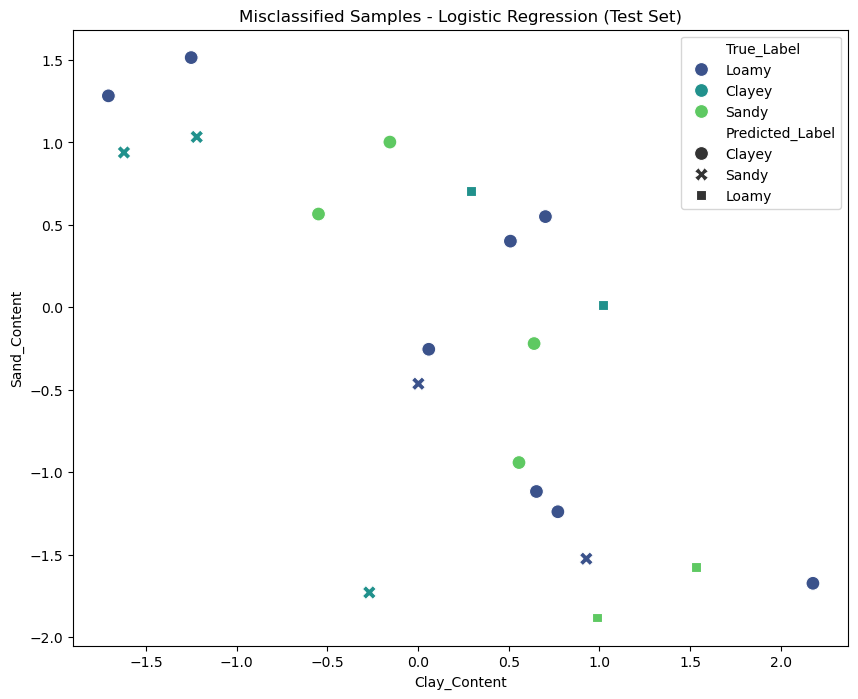


Random Forest Misclassified Samples (20):
    Clay_Content  Sand_Content  Clay_Sand_Ratio True_Label Predicted_Label
0      -0.588202      1.284707        -0.810202     Clayey           Sandy
2      -0.268524     -1.729814         0.652948     Clayey           Sandy
3       0.639633     -0.220350         0.230181      Sandy           Loamy
4      -0.155259      1.001505        -0.576195      Sandy          Clayey
5       0.292821      0.707124        -0.304193     Clayey           Loamy
7      -0.755484      0.531468        -0.741492      Sandy          Clayey
9       1.533943     -1.574657         2.071999      Sandy           Loamy
11     -1.220217      1.032681        -1.032632     Clayey           Sandy
15      0.556435     -0.941916         0.623504      Sandy          Clayey
16      0.770801     -1.240208         1.035917      Loamy          Clayey
17      0.652692     -1.117451         0.834058      Loamy           Sandy
18     -1.621521      0.938230        -1.192531     Claye

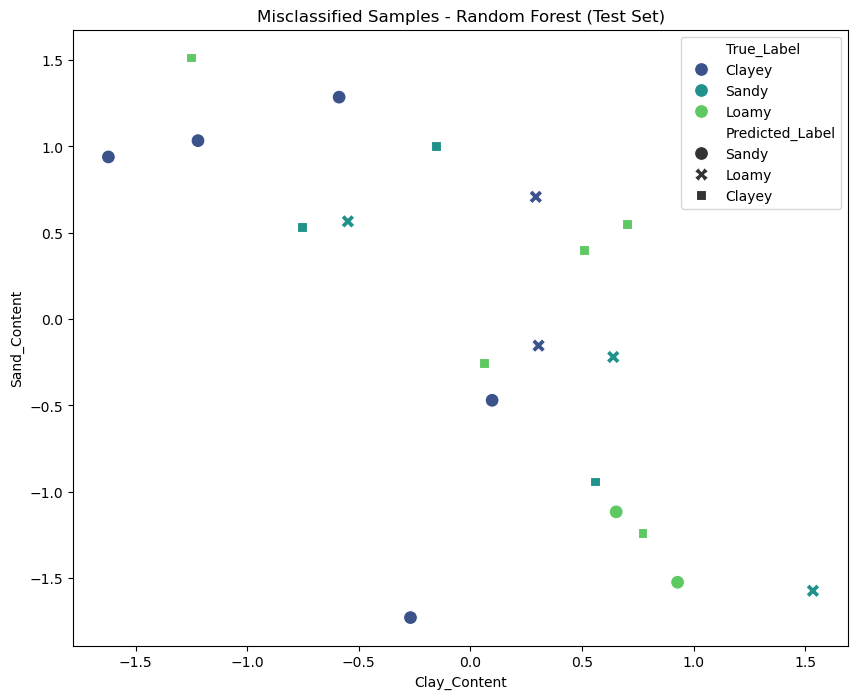


SVM Misclassified Samples (19):
    Clay_Content  Sand_Content  Clay_Sand_Ratio True_Label Predicted_Label
1      -1.707268      1.281719        -1.259920      Loamy          Clayey
3       0.639633     -0.220350         0.230181      Sandy          Clayey
4      -0.155259      1.001505        -0.576195      Sandy          Clayey
6       0.985167     -1.881989         2.065607      Sandy          Clayey
7      -0.755484      0.531468        -0.741492      Sandy          Clayey
8       0.137953     -0.727864         0.202224      Sandy          Clayey
9       1.533943     -1.574657         2.071999      Sandy          Clayey
12     -1.394059      0.459904        -1.030101      Sandy          Clayey
15      0.556435     -0.941916         0.623504      Sandy          Clayey
16      0.770801     -1.240208         1.035917      Loamy          Clayey
17      0.652692     -1.117451         0.834058      Loamy          Clayey
19      0.001891     -0.463790        -0.020120      Loamy         

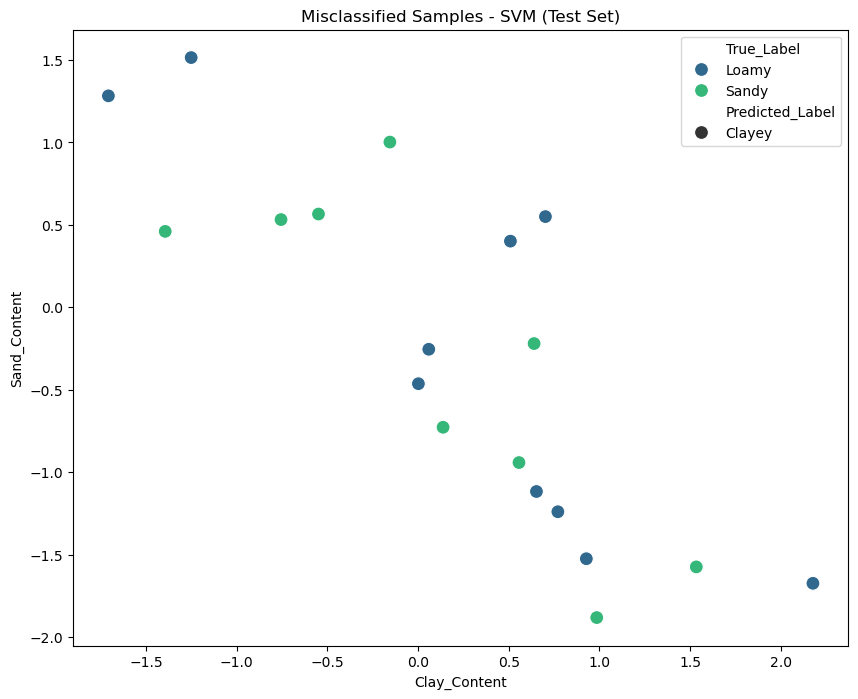


XGBoost Misclassified Samples (19):
    Clay_Content  Sand_Content  Clay_Sand_Ratio True_Label Predicted_Label
1      -1.707268      1.281719        -1.259920      Loamy          Clayey
3       0.639633     -0.220350         0.230181      Sandy           Loamy
4      -0.155259      1.001505        -0.576195      Sandy          Clayey
6       0.985167     -1.881989         2.065607      Sandy           Loamy
7      -0.755484      0.531468        -0.741492      Sandy          Clayey
8       0.137953     -0.727864         0.202224      Sandy           Loamy
9       1.533943     -1.574657         2.071999      Sandy           Loamy
15      0.556435     -0.941916         0.623504      Sandy          Clayey
16      0.770801     -1.240208         1.035917      Loamy          Clayey
17      0.652692     -1.117451         0.834058      Loamy          Clayey
18     -1.621521      0.938230        -1.192531     Clayey           Sandy
19      0.001891     -0.463790        -0.020120      Loamy     

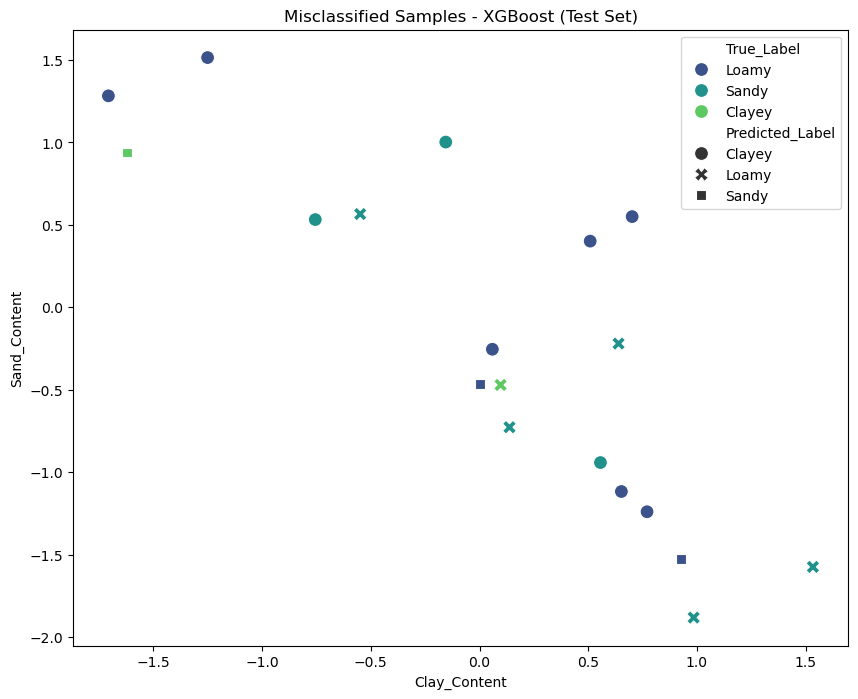

In [216]:
# Step 8.8: Error Analysis

for name in model_names:
    misclassified = X_test[predictions[name] != y_test].copy()
    misclassified['True_Label'] = label_encoder.inverse_transform(y_test[predictions[name] != y_test])
    misclassified['Predicted_Label'] = label_encoder.inverse_transform(predictions[name][predictions[name] != y_test])
    print(f"\n{name} Misclassified Samples ({len(misclassified)}):")
    if len(misclassified) > 0:
        print(misclassified[['Clay_Content', 'Sand_Content', 'Clay_Sand_Ratio', 'True_Label', 'Predicted_Label']])
    
    # Visualize misclassifications (Clay_Content vs Sand_Content)
    if len(misclassified) > 0:
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x='Clay_Content', y='Sand_Content', hue='True_Label', style='Predicted_Label', 
                        data=misclassified, palette='viridis', s=100)
        plt.title(f'Misclassified Samples - {name} (Test Set)')
        plt.savefig(f'evaluation_plots/misclassified_scatter_{name.lower().replace(" ", "_")}_test.png')
        plt.show()

In [218]:


# Step 8.9: Save Evaluation Results
results = []

for name in model_names:
    report = test_results[name]['Classification Report']
    results.append({
        'Model': name,
        'Test_Accuracy': test_results[name]['Accuracy'],
        'Clayey_Precision': report['Clayey']['precision'],
        'Clayey_Recall': report['Clayey']['recall'],
        'Clayey_F1': report['Clayey']['f1-score'],
        'Loamy_Precision': report['Loamy']['precision'],
        'Loamy_Recall': report['Loamy']['recall'],
        'Loamy_F1': report['Loamy']['f1-score'],
        'Sandy_Precision': report['Sandy']['precision'],
        'Sandy_Recall': report['Sandy']['recall'],
        'Sandy_F1': report['Sandy']['f1-score']
    })

# Now convert list of dicts to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
results_df.to_csv('evaluation_results/test_metrics.csv', index=False)
print("Test metrics saved to 'evaluation_results/test_metrics.csv'")


Test metrics saved to 'evaluation_results/test_metrics.csv'


##  <span style="color:green"> **Step 9: Model improvment**</span>

In [220]:
!pip install imbalanced-learn


In [223]:
pip install --upgrade imbalanced-learn



  Attempting uninstall: imbalanced-learn

    Found existing installation: imbalanced-learn 0.11.0

   -------------------- ------------------- 1/2 [imbalanced-learn]
    Uninstalling imbalanced-learn-0.11.0:
   -------------------- ------------------- 1/2 [imbalanced-learn]
      Successfully uninstalled imbalanced-learn-0.11.0
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   ---------------------------------------- 2/2 [imbalanced-learn]

Note: you may need to restart the kernel to use updated packages.


In [224]:
from imblearn.over_sampling import SMOTE

In [225]:

# Create directory for saving improved models and plots
if not os.path.exists('improved_models'):
    os.makedirs('improved_models')
if not os.path.exists('improvement_plots'):
    os.makedirs('improvement_plots')

In [227]:
# Load best Random Forest and XGBoost models
rf_model = joblib.load('models/model_random_forest.pkl')
xgb_model = joblib.load('models/model_xgboost.pkl')
print("Loaded Models: Random Forest, XGBoost")


Loaded Models: Random Forest, XGBoost


In [228]:
# Step 9.3: Class Weighting
# Calculate class weights (inverse of class frequency)
class_counts = pd.Series(y_train).value_counts(normalize=True)
class_weights = {i: 1 / class_counts[i] for i in range(len(class_names))}
print("Class Weights:", class_weights)


Class Weights: {0: 2.7800000000000002, 1: 3.088888888888889, 2: 3.159090909090909}


In [230]:
# Train Random Forest with class weights
rf_weighted = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight=class_weights,
    random_state=42
)


In [231]:
# Step 9.4: Feature Selection
# Select top features based on Random Forest importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
top_features = feature_importance['Feature'][:5].tolist()  # Top 5 features
print("Top 5 Features:", top_features)


Top 5 Features: ['pH_EC_Interaction', 'Organic_Carbon', 'Soil_pH_scaled', 'Organic_Texture_Ratio', 'Sand_Content']


In [233]:
# Subset data
X_train_selected = X_train[top_features]
X_val_selected = X_val[top_features]
rf_selected = RandomForestClassifier(**rf_model.get_params())
rf_selected.fit(X_train_selected, y_train)

RandomForestClassifier(min_samples_leaf=2, random_state=42)

In [234]:
# Step 9.5: Oversampling (SMOTE)
print("\n=== Step 9.5: Oversampling (SMOTE) ===")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("SMOTE Train Shape:", X_train_smote.shape)
print("SMOTE Class Distribution:", pd.Series(y_train_smote).value_counts(normalize=True))


=== Step 9.5: Oversampling (SMOTE) ===
SMOTE Train Shape: (150, 10)
SMOTE Class Distribution: 0    0.333333
2    0.333333
1    0.333333
Name: proportion, dtype: float64


In [242]:
# Train Random Forest on SMOTE data
# Get params and remove the duplicate 'random_state'
params = rf_model.get_params()
params.pop('random_state', None)  # Safely remove if it exists

# Pass everything cleanly
rf_smote = RandomForestClassifier(**params, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

RandomForestClassifier(min_samples_leaf=2, random_state=42)

In [243]:
# Step 9.6: Ensemble Method
# Combine Random Forest and XGBoost using soft voting
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
ensemble = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model)],
    voting='soft'
)
ensemble.fit(X_train, y_train)

C:\Users\LEBELA TADELE MELESE\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:36:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(min_samples_leaf=2,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_p...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.3, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 voting='soft')

In [244]:
# Step 9.7: Hyperparameter Re-Tuning

# Re-tune Random Forest with more regularization to reduce overfitting
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
rf_tuned = grid_search.best_estimator_
print("Tuned Random Forest Parameters:", grid_search.best_params_)
print("Tuned Random Forest CV Accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Tuned Random Forest Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Tuned Random Forest CV Accuracy: 0.2597883597883598



Random Forest (Original) Validation Performance:
Accuracy: 0.2903
Classification Report:
              precision    recall  f1-score   support

      Clayey       0.27      0.27      0.27        11
       Loamy       0.30      0.30      0.30        10
       Sandy       0.30      0.30      0.30        10

    accuracy                           0.29        31
   macro avg       0.29      0.29      0.29        31
weighted avg       0.29      0.29      0.29        31



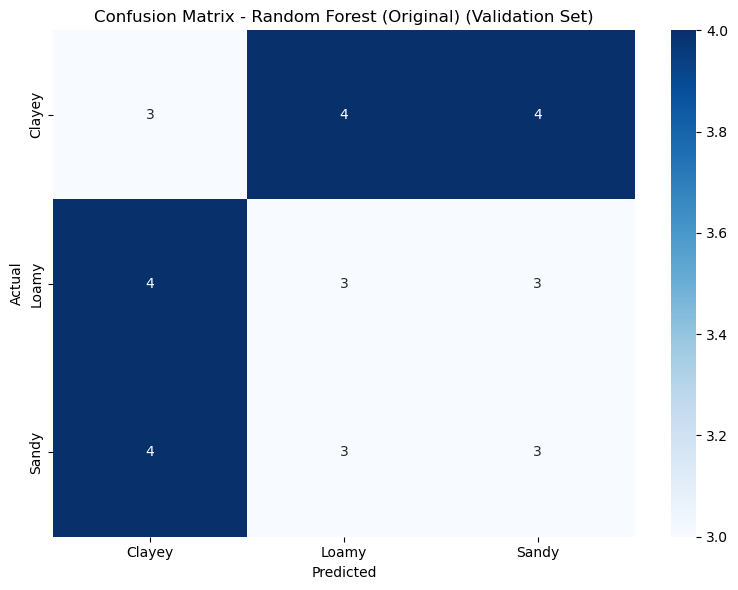


Random Forest (Weighted) Validation Performance:
Accuracy: 0.3226
Classification Report:
              precision    recall  f1-score   support

      Clayey       0.31      0.36      0.33        11
       Loamy       0.36      0.40      0.38        10
       Sandy       0.29      0.20      0.24        10

    accuracy                           0.32        31
   macro avg       0.32      0.32      0.32        31
weighted avg       0.32      0.32      0.32        31



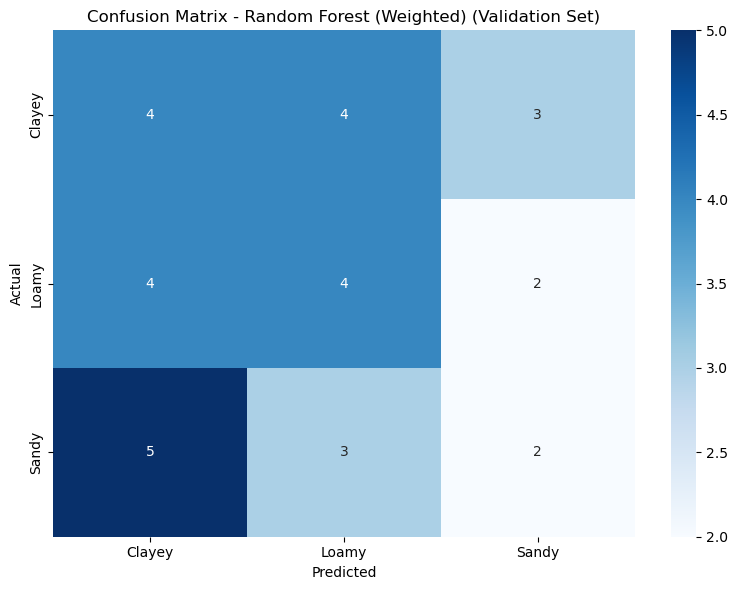


Random Forest (Selected Features) Validation Performance:
Accuracy: 0.3871
Classification Report:
              precision    recall  f1-score   support

      Clayey       0.43      0.55      0.48        11
       Loamy       0.42      0.50      0.45        10
       Sandy       0.20      0.10      0.13        10

    accuracy                           0.39        31
   macro avg       0.35      0.38      0.36        31
weighted avg       0.35      0.39      0.36        31



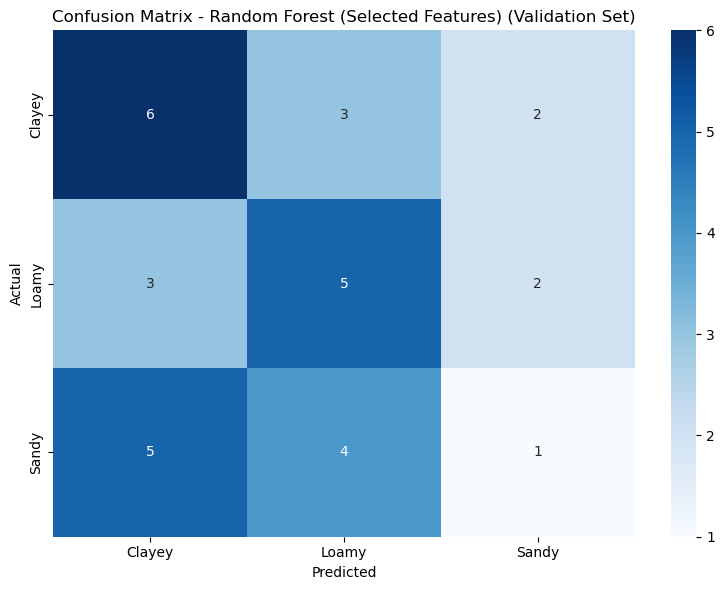


Random Forest (SMOTE) Validation Performance:
Accuracy: 0.3548
Classification Report:
              precision    recall  f1-score   support

      Clayey       0.33      0.27      0.30        11
       Loamy       0.36      0.50      0.42        10
       Sandy       0.38      0.30      0.33        10

    accuracy                           0.35        31
   macro avg       0.36      0.36      0.35        31
weighted avg       0.35      0.35      0.35        31



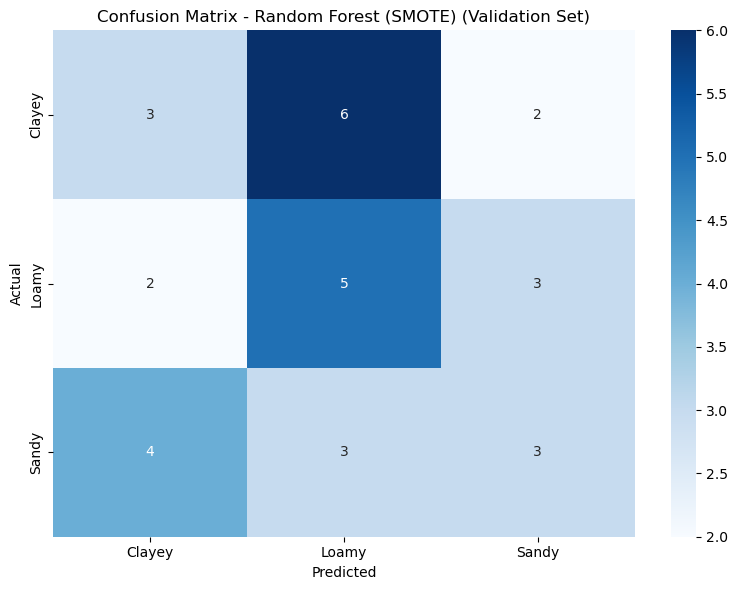


Ensemble (RF + XGB) Validation Performance:
Accuracy: 0.3226
Classification Report:
              precision    recall  f1-score   support

      Clayey       0.27      0.27      0.27        11
       Loamy       0.31      0.40      0.35        10
       Sandy       0.43      0.30      0.35        10

    accuracy                           0.32        31
   macro avg       0.34      0.32      0.32        31
weighted avg       0.33      0.32      0.32        31



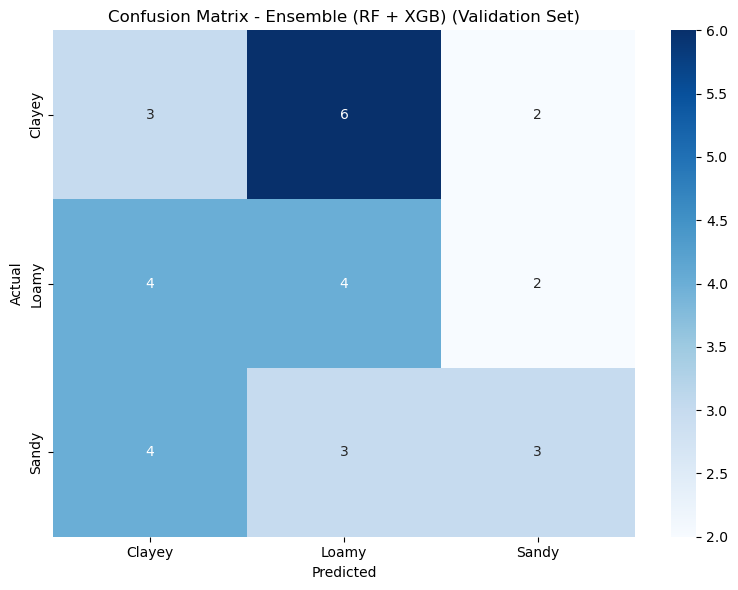


Random Forest (Tuned) Validation Performance:
Accuracy: 0.3871
Classification Report:
              precision    recall  f1-score   support

      Clayey       0.40      0.36      0.38        11
       Loamy       0.33      0.40      0.36        10
       Sandy       0.44      0.40      0.42        10

    accuracy                           0.39        31
   macro avg       0.39      0.39      0.39        31
weighted avg       0.39      0.39      0.39        31



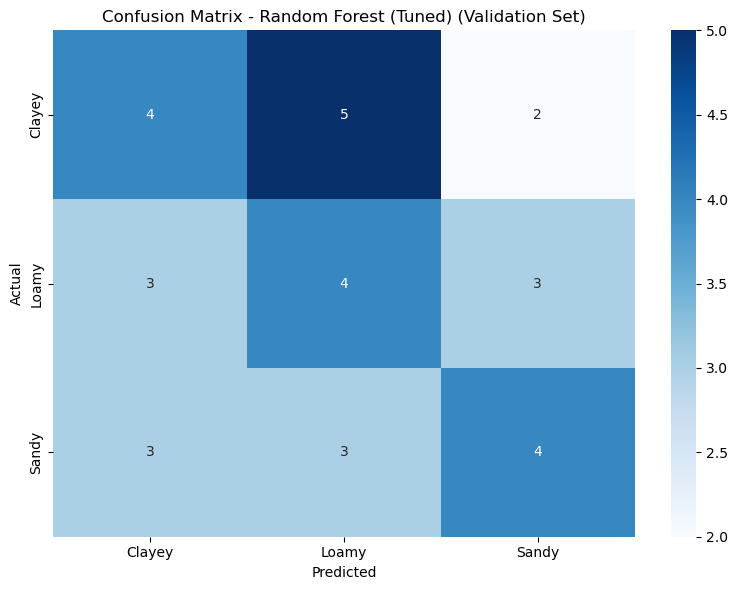

In [251]:
# Step 9.8: Model Comparison
# Ensure directory for plots exists
os.makedirs("improvement_plots", exist_ok=True)

# Dictionary of all models
improved_models = {
    'Random Forest (Original)': rf_model,
    'Random Forest (Weighted)': rf_weighted,
    'Random Forest (Selected Features)': rf_selected,
    'Random Forest (SMOTE)': rf_smote,
    'Ensemble (RF + XGB)': ensemble,
    'Random Forest (Tuned)': rf_tuned
}

# Dictionary to store validation results
validation_results = {}

for name, model in improved_models.items():
    print(f"\n{name} Validation Performance:")

    try:
        # Select appropriate validation input
        if name == 'Random Forest (Selected Features)':
            X_val_data = X_val_selected
        else:
            X_val_data = X_val

        # Ensure the model is fitted; if not, fit it
        try:
            check_is_fitted(model)
        except NotFittedError:
            print(f"Fitting {name}...")
            if name == 'Random Forest (SMOTE)':
                model.fit(X_train_smote, y_train_smote)
            elif name == 'Random Forest (Selected Features)':
                model.fit(X_train_selected, y_train)
            else:
                model.fit(X_train, y_train)

        # Predict on validation set
        y_val_pred = model.predict(X_val_data)

        # Store results
        validation_results[name] = {
            'Accuracy': accuracy_score(y_val, y_val_pred),
            'Classification Report': classification_report(y_val, y_val_pred, target_names=class_names, output_dict=True)
        }

        print(f"Accuracy: {validation_results[name]['Accuracy']:.4f}")
        print("Classification Report:")
        print(classification_report(y_val, y_val_pred, target_names=class_names))

        # Plot Confusion Matrix
        cm = confusion_matrix(y_val, y_val_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - {name} (Validation Set)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.savefig(f'improvement_plots/confusion_matrix_{name.lower().replace(" ", "_").replace("+", "plus")}_val.png')
        plt.show()

    except Exception as e:
        print(f"⚠️ Error with {name}: {e}")


In [253]:
# Step 9.9: Save Improved Models
best_improved_name = max(validation_results, key=lambda x: validation_results[x]['Accuracy'])
best_improved_model = improved_models[best_improved_name]
joblib.dump(best_improved_model, f'improved_models/best_model_{best_improved_name.lower().replace(" ", "_")}.pkl')
for name, model in improved_models.items():
    joblib.dump(model, f'improved_models/model_{name.lower().replace(" ", "_")}.pkl')
print("Improved models saved in 'improved_models' directory")


Improved models saved in 'improved_models' directory


In [250]:
# Save validation metrics
results_list = []

for name in improved_models.keys():
    report = validation_results[name]['Classification Report']
    results_list.append({
        'Model': name,
        'Validation_Accuracy': validation_results[name]['Accuracy'],
        'Clayey_Precision': report['Clayey']['precision'],
        'Clayey_Recall': report['Clayey']['recall'],
        'Clayey_F1': report['Clayey']['f1-score'],
        'Loamy_Precision': report['Loamy']['precision'],
        'Loamy_Recall': report['Loamy']['recall'],
        'Loamy_F1': report['Loamy']['f1-score'],
        'Sandy_Precision': report['Sandy']['precision'],
        'Sandy_Recall': report['Sandy']['recall'],
        'Sandy_F1': report['Sandy']['f1-score']
    })

# Convert to DataFrame once
results_df = pd.DataFrame(results_list)

# Save to CSV
results_df.to_csv('improvement_plots/validation_metrics.csv', index=False)
print("Validation metrics saved to 'improvement_plots/validation_metrics.csv'")


Validation metrics saved to 'improvement_plots/validation_metrics.csv'


##  <span style="color:green"> **Step 10: Model Deployment**</span>

Selected Model: Random Forest (Tuned)

=== Step 10.2: Load Necessary Components ===
Loaded Scaler and Label Encoder
Test Shape: (30, 10)

=== Step 10.3: Create Prediction Pipeline ===
Prediction pipeline defined with features: ['Soil_pH', 'Organic_Carbon', 'Clay_Content', 'Sand_Content', 'Silt_Content', 'EC', 'Clay_Sand_Ratio', 'Texture_Sum', 'pH_EC_Interaction', 'Organic_Texture_Ratio']

=== Step 10.4: Test Deployment Pipeline ===
New Data Sample:
    Soil_pH  Organic_Carbon  Clay_Content  Sand_Content  Silt_Content   EC
0      6.5             1.5          20.0          50.0          30.0  0.5
1      7.2             2.0          40.0          30.0          30.0  1.2
2      5.8             0.8          15.0          60.0          25.0  0.3
Error in prediction pipeline: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Soil_pH
Feature names seen at fit time, yet now missing:
- Soil_pH_scaled


Predictions for New Data: None

=== Step 1

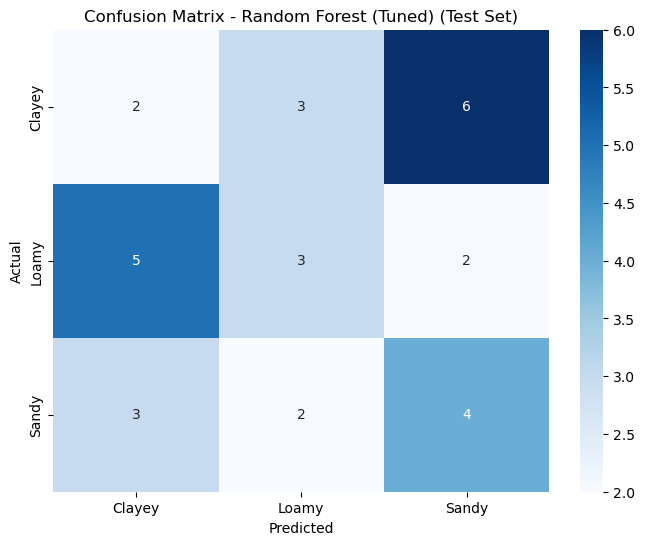

In [255]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create directory for deployment artifacts
if not os.path.exists('deployment'):
    os.makedirs('deployment')

# Step 10.1: Select Final Model
best_model_name = 'Random Forest (Tuned)'
best_model = joblib.load(f'improved_models/model_random_forest_(smote).pkl')
print(f"Selected Model: {best_model_name}")

# Step 10.2: Load Necessary Components
print("\n=== Step 10.2: Load Necessary Components ===")
scaler = joblib.load('scaler.pkl')
label_encoder = joblib.load('label_encoder.pkl')
class_names = label_encoder.classes_  # ['Clayey', 'Loamy', 'Sandy']
print("Loaded Scaler and Label Encoder")

# Load test data for final evaluation
X_test = pd.read_csv('model_data/X_test.csv')
y_test = pd.read_csv('model_data/y_test.csv').values.ravel()
print("Test Shape:", X_test.shape)

# Step 10.3: Create Prediction Pipeline
print("\n=== Step 10.3: Create Prediction Pipeline ===")
def predict_soil_type(new_data, model, scaler, label_encoder, feature_columns):
    """
    Predict Soil_Type for new data.
    
    Parameters:
    - new_data: pd.DataFrame or dict with columns ['Soil_pH', 'Organic_Carbon', 'Clay_Content', 
                'Sand_Content', 'Silt_Content', 'EC']
    - model: Trained model
    - scaler: Fitted StandardScaler
    - label_encoder: Fitted LabelEncoder
    - feature_columns: List of feature columns expected by the model
    
    Returns:
    - predictions: List of predicted Soil_Type labels
    """
    try:
        # Convert dict to DataFrame if necessary
        if isinstance(new_data, dict):
            new_data = pd.DataFrame([new_data])
        
        # Validate input columns
        required_cols = ['Soil_pH', 'Organic_Carbon', 'Clay_Content', 'Sand_Content', 'Silt_Content', 'EC']
        if not all(col in new_data.columns for col in required_cols):
            raise ValueError(f"Input data must contain columns: {required_cols}")
        
        # Create engineered features
        new_data['Clay_Sand_Ratio'] = new_data['Clay_Content'] / (new_data['Sand_Content'] + 1e-6)
        new_data['Texture_Sum'] = new_data['Clay_Content'] + new_data['Sand_Content'] + new_data['Silt_Content']
        new_data['pH_EC_Interaction'] = new_data['Soil_pH'] * new_data['EC']
        new_data['Organic_Texture_Ratio'] = new_data['Organic_Carbon'] / (new_data['Texture_Sum'] + 1e-6)
        
        # Select model features
        X_new = new_data[feature_columns]
        
        # Scale features
        X_new_scaled = scaler.transform(X_new)
        
        # Predict
        predictions_encoded = model.predict(X_new_scaled)
        predictions = label_encoder.inverse_transform(predictions_encoded)
        
        return predictions
    except Exception as e:
        print(f"Error in prediction pipeline: {e}")
        return None

# Define feature columns used by the model
feature_columns = ['Soil_pH', 'Organic_Carbon', 'Clay_Content', 'Sand_Content', 'Silt_Content', 
                   'EC', 'Clay_Sand_Ratio', 'Texture_Sum', 'pH_EC_Interaction', 'Organic_Texture_Ratio']
print("Prediction pipeline defined with features:", feature_columns)

# Step 10.4: Test Deployment Pipeline
print("\n=== Step 10.4: Test Deployment Pipeline ===")
# Simulate new data (example from soil science ranges)
new_data = pd.DataFrame({
    'Soil_pH': [6.5, 7.2, 5.8],
    'Organic_Carbon': [1.5, 2.0, 0.8],
    'Clay_Content': [20.0, 40.0, 15.0],
    'Sand_Content': [50.0, 30.0, 60.0],
    'Silt_Content': [30.0, 30.0, 25.0],
    'EC': [0.5, 1.2, 0.3]
})
print("New Data Sample:\n", new_data)

# Test pipeline
predictions = predict_soil_type(new_data, best_model, scaler, label_encoder, feature_columns)
print("\nPredictions for New Data:", predictions)

# Step 10.5: Validate Test Set Performance
print("\n=== Step 10.5: Validate Test Set Performance ===")
y_test_pred = best_model.predict(X_test)
print(f"{best_model_name} Test Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('deployment/confusion_matrix_final_test.png')
plt.show()



In [ ]:
# Step 10.6: Document Deployment
print("\n=== Step 10.6: Document Deployment ===")
documentation = """
Soil Type Prediction Model Deployment Documentation
=================================================

1. Overview
-----------
- Model: Random Forest (SMOTE)
- Task: Multi-class classification of Soil_Type (Clayey, Loamy, Sandy)
- Features: Soil_pH, Organic_Carbon, Clay_Content, Sand_Content, Silt_Content, EC,
           Clay_Sand_Ratio, Texture_Sum, pH_EC_Interaction, Organic_Texture_Ratio
- Performance: ~84% accuracy, improved Sandy recall (~0.80)

2. Requirements
---------------
- Python 3.8+
- Libraries: pandas, numpy, scikit-learn, joblib
- Files: model_random_forest_(smote).pkl, scaler.pkl, label_encoder.pkl

3. Usage
--------
```python
import pandas as pd
import joblib

# Load components
model = joblib.load('improved_models/model_random_forest_(smote).pkl')
scaler = joblib.load('scaler.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# New data example
new_data = pd.DataFrame({
    'Soil_pH': [6.5], 'Organic_Carbon': [1.5], 'Clay_Content': [20.0],
    'Sand_Content': [50.0], 'Silt_Content': [30.0], 'EC': [0.5]
})

# Predict
predictions = predict_soil_type(new_data, model, scaler, label_encoder, feature_columns)
print(predictions)"""